# SPS MBB Dipole -- NCS Streaming Supercycle Analysis

**Measurement session:** `20260206_144537_SPS_MBB` (extended run)
**Segment:** NCS
**Magnet:** MBB (normal dipole, m=1)
**Kn calibration:** AC compensation (cross-session from MBA, same coil)

This notebook processes a **streaming** measurement where the SPS
supercycle repeats ~20 times.  The rotating coil produces unreliable
harmonics during fast current ramps, so we:

1. Detect **current plateaus** (flat injection + flat tops) from the
   per-turn current stability.
2. Classify each plateau by current level to identify the machine
   cycle type.
3. Process harmonics **only on plateau turns** and average per level.
4. Track **hysteresis**: field at injection depends on the preceding
   cycle (LHC vs SFTPRO vs MD).

| Section | Content |
|---------|----------|
| 1 | Configuration & imports |
| 2 | Kn calibration |
| 3 | Raw data loading & per-turn overview |
| 4 | Plateau detection & cycle identification |
| 5 | Raw signals with plateau annotations |
| 6 | Pipeline processing (plateau turns only) |
| 7 | B1 analysis per plateau |
| 8 | Transfer function B/I vs I |
| 9 | b2 (quadrupole) per plateau |
| 10 | b3 (sextupole) per plateau |
| 11 | Hysteresis analysis |
|    | 11a. MD1 injection hysteresis (true plateau, 24 turns/SC) |
|    | 11b. SFTPRO flat-top evolution (current ramps, 3-4 turns/SC) |
|    | 11c. Within-plateau settling (eddy currents vs current ramp) |
|    | 11d. Turn-by-turn scatter |
|    | 11e. Hysteresis delta (deviation from steady state) |
| 12 | Summary & export |

---
## 1. Configuration & Imports

In [94]:
# =====================================================================
#  USER-SELECTABLE PARAMETERS  --  edit this section before running
# =====================================================================

# --- Dataset ---
SEGMENT = "NCS"
SESSION = "2026_02_06/01_200_extended/20260206_144537_SPS_MBB"
MEAS_SUBDIR = "20260206_144559_MBB"
KN_CROSS_SESSION = "20251212_171026_SPS_MBA/CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"

# --- Magnet / coil ---
MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
L_COIL = 0.47             # coil length [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution

# --- Pipeline ---
OPTIONS = ("dri", "rot", "cel", "fed")
MIN_B1_T = 1e-4

# --- Plateau detection ---
PLATEAU_I_RANGE_MAX = 2.5   # A  (lowered from 3.0)

# --- Reference supercycle structure ---
# Each supercycle = LHC_pilot + MD1 + SFTPRO (~53 s), repeated 20 times.
# Reference cycles (from cycles_used/):
#   LHC_pilot : 13.2 s  idle(155A) -> inj(302A, 1.2s) -> ft(5785A, 0.5s) -> down
#   MD1       : 27.6 s  idle(155A) -> inj(301A, 25 s) -> ft(2340A, 0.5s) -> down
#   SFTPRO    : 10.8 s  idle(155A) -> ramp -> ft(4818A, 4.8s) -> down
#
# What the plateau detection finds (per supercycle, ~52 turns):
#   "injection" groups (~25 turns at 301 A) = MD1 long injection plateau
#   "flat-high" turns (~4 turns at 4815 A)  = SFTPRO flat-top (400 GeV)
#   LHC flat-top (5785 A) is too brief (<1 turn) for plateau detection
#   MD1 flat-top (2340 A) is too brief (<1 turn) for plateau detection

# =====================================================================

kn_label = KN_CROSS_SESSION.split("/")[-1]
print(f"SPS MBB Dipole -- {SEGMENT} Streaming Supercycle Analysis")
print("=" * 60)
print(f"  Session       : {SESSION}")
print(f"  Kn file       : {kn_label} (cross-session from MBA)")
print(f"  Magnet order  : {MAGNET_ORDER} (dipole)")
print(f"  Plateau thr   : I range < {PLATEAU_I_RANGE_MAX} A (peak-to-peak)")
print(f"  SC structure  : LHC_pilot -> MD1 -> SFTPRO x20")

SPS MBB Dipole -- NCS Streaming Supercycle Analysis
  Session       : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
  Kn file       : Kn_values_Seg_Main_A_AC.txt (cross-session from MBA)
  Magnet order  : 1 (dipole)
  Plateau thr   : I range < 2.5 A (peak-to-peak)
  SC structure  : LHC_pilot -> MD1 -> SFTPRO x20


In [95]:
import sys
from pathlib import Path
import re, warnings
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

repo_root = Path("../..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from rotating_coil_analyzer.analysis.kn_pipeline import (
    load_segment_kn_txt,
)
from rotating_coil_analyzer.analysis.utility_functions import (
    compute_block_averaged_range,
    detect_plateau_turns,
    classify_current,
    find_contiguous_groups,
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

print("Imports ready.")

Imports ready.


In [96]:
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

SESSION_DIR = REPO_ROOT / "measurements" / SESSION
RUN_DIR = SESSION_DIR / MEAS_SUBDIR
KN_PATH = REPO_ROOT / "measurements" / KN_CROSS_SESSION

# Find the NCS raw file
FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)
ncs_files = []
for f in sorted(RUN_DIR.iterdir()):
    m = FILE_PAT.search(f.name)
    if m and m.group(3) == SEGMENT:
        ncs_files.append(f)

RAW_FILE = ncs_files[0]
print(f"Repo root   : {REPO_ROOT}")
print(f"Session dir : {SESSION_DIR}")
print(f"Raw file    : {RAW_FILE.name}")
print(f"Kn file     : {KN_PATH}")
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}"
assert RAW_FILE.exists(), f"Raw file not found: {RAW_FILE}" 

Repo root   : C:\Users\albellel\python-projects\rotating-coil-analyzer
Session dir : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_06\01_200_extended\20260206_144537_SPS_MBB
Raw file    : 20260206_144559_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt
Kn file     : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\20251212_171026_SPS_MBA\CRMMMMH_AV-00000001\Kn_values_Seg_Main_A_AC.txt


---
## 2. Kn Calibration

In [97]:
kn = load_segment_kn_txt(str(KN_PATH))
H = len(kn.orders)
print(f"Kn: {H} harmonics from {KN_PATH.name} (cross-session)")

kn_abs_n1 = abs(kn.kn_abs[0])
kn_cmp_n1 = abs(kn.kn_cmp[0])
ratio_n1 = kn_abs_n1 / max(kn_cmp_n1, 1e-30)
print(f"  Abs/Cmp suppression (n=1): {ratio_n1:.0f}x")

Kn: 15 harmonics from Kn_values_Seg_Main_A_AC.txt (cross-session)
  Abs/Cmp suppression (n=1): 20268x


---
## 3. Raw Data Loading & Per-Turn Overview

In [98]:
Ns = SAMPLES_PER_TURN
raw = np.loadtxt(RAW_FILE)
n_turns = raw.shape[0] // Ns
n_keep = n_turns * Ns
ncols = raw.shape[1]
print(f"Raw shape: {raw.shape} -> {n_turns} turns, {ncols} columns")
print(f"Time span: {raw[-1,0] - raw[0,0]:.1f} s ({(raw[-1,0] - raw[0,0])/60:.1f} min)")

# Reshape into (n_turns, Ns)
t_all   = raw[:n_keep, 0].reshape(n_turns, Ns)
flux_abs_all = raw[:n_keep, 1].reshape(n_turns, Ns)
flux_cmp_all = raw[:n_keep, 2].reshape(n_turns, Ns)
I_all   = raw[:n_keep, 3].reshape(n_turns, Ns)

# Pick a high-current turn for channel detection
I_mean_quick = I_all.mean(axis=1)
best_turn = np.argmax(np.abs(I_mean_quick))
r1 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 1])
r2 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 2])
SWAP_FLUX = (r2 > r1)
COL_ABS = 2 if SWAP_FLUX else 1
COL_CMP = 1 if SWAP_FLUX else 2
COL_I = 3

# Voltage channel
COL_V = 4 if ncols > 4 else None

# Re-assign flux arrays if swapped
if SWAP_FLUX:
    flux_abs_all = raw[:n_keep, COL_ABS].reshape(n_turns, Ns)
    flux_cmp_all = raw[:n_keep, COL_CMP].reshape(n_turns, Ns)

V_all = raw[:n_keep, COL_V].reshape(n_turns, Ns) if COL_V else None

print(f"  col {COL_ABS} -> flux abs (range={r1 if not SWAP_FLUX else r2:.4e})")
print(f"  col {COL_CMP} -> flux cmp (range={r2 if not SWAP_FLUX else r1:.4e})")
print(f"  col {COL_I} -> current")
if COL_V is not None:
    print(f"  col {COL_V} -> voltage")
if SWAP_FLUX:
    print("  (flux columns swapped)")

Raw shape: (1086464, 5) -> 1061 turns, 5 columns
Time span: 1061.0 s (17.7 min)
  col 1 -> flux abs (range=2.9374e-03)
  col 2 -> flux cmp (range=3.6848e-06)
  col 3 -> current
  col 4 -> voltage


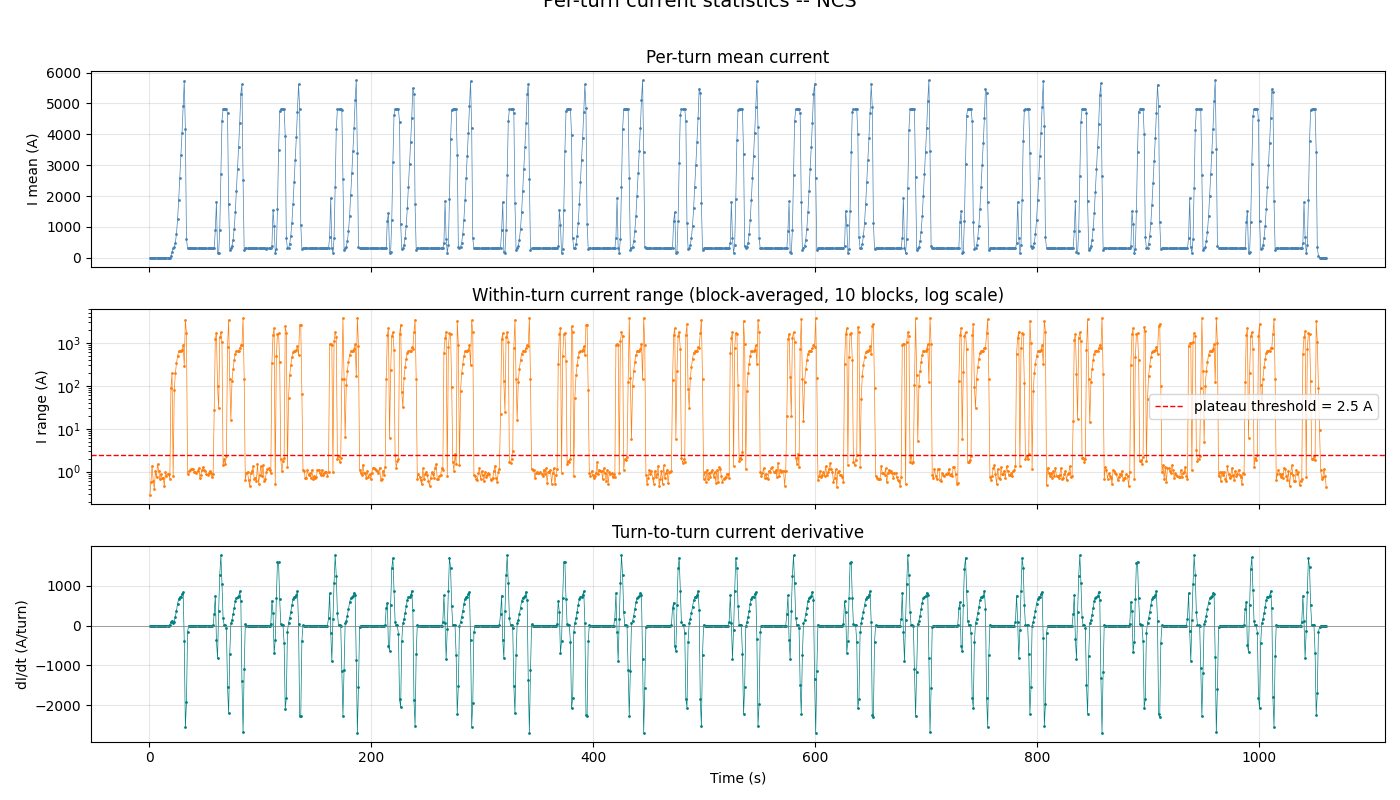

Total turns: 1061
I range: -0.2 .. 5750.4 A
Plateau-range values on flattest turns: [0.2813772  0.39759821 0.44276908 0.44559232 0.45829658] A


In [99]:
# Per-turn statistics
I_mean  = I_all.mean(axis=1)
t_mean  = t_all.mean(axis=1)

# Robust current range: block-averaged peak-to-peak per turn
N_BLOCKS = 10
I_range, I_blocks = compute_block_averaged_range(I_all, Ns, N_BLOCKS)

# Turn-to-turn dI/dt (for ramp detection)
dI_dt = np.gradient(I_mean)  # A/turn

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

ax = axes[0]
ax.plot(t_mean, I_mean, ".-", markersize=2, linewidth=0.5, color="steelblue")
ax.set_ylabel("I mean (A)")
ax.set_title("Per-turn mean current")

ax = axes[1]
ax.semilogy(t_mean, I_range, ".-", markersize=2, linewidth=0.5, color="tab:orange")
ax.axhline(PLATEAU_I_RANGE_MAX, color="red", linestyle="--", linewidth=1,
           label=f"plateau threshold = {PLATEAU_I_RANGE_MAX} A")
ax.set_ylabel("I range (A)")
ax.set_title(f"Within-turn current range (block-averaged, {N_BLOCKS} blocks, log scale)")
ax.legend()

ax = axes[2]
ax.plot(t_mean, dI_dt, ".-", markersize=2, linewidth=0.5, color="teal")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_ylabel("dI/dt (A/turn)")
ax.set_xlabel("Time (s)")
ax.set_title("Turn-to-turn current derivative")

fig.suptitle(f"Per-turn current statistics -- {SEGMENT}", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print(f"Total turns: {n_turns}")
print(f"I range: {I_mean.min():.1f} .. {I_mean.max():.1f} A")
print(f"Plateau-range values on flattest turns: "
      f"{np.sort(I_range)[:5]} A")

---
## 4. Plateau Detection & Cycle Identification

**Plateau criterion:** a turn is on a current plateau if **all three**
conditions are met:

1. The within-turn standard deviation of the current is below the threshold
2. The turn **starts** on the plateau (first samples are close to the turn mean)
3. The turn **ends** on the plateau (last samples are close to the turn mean)

This ensures that only turns fully contained within a stable plateau are
accepted -- no ramp contamination at the boundaries.

Current levels are then clustered to identify:
- **Injection** (~300 A, SPS 26 GeV)
- **Flat-top high** (~4815 A)
- **Flat-top low** (~3290 A, appears every few supercycles)

Plateau detection: 599 turns accepted, 0 boundary-rejected

PASS / NO-PASS RULES  (threshold = 2.5 A)
  Rule (a)  block-averaged I range < 2.5 A
            current must be flat (noise-filtered peak-to-peak)
            -> 599 / 1061 turns pass
  Rule (b)  |I_first_block - I_mean| < 2.5 A
            turn must start on the plateau
            -> 599 / 599 (of range-ok) pass
  Rule (c)  |I_last_block - I_mean| < 2.5 A
            turn must end on the plateau
            -> 599 / 599 (of range-ok) pass
  ALL THREE -> 599 plateau turns
  Boundary-rejected (pass a, fail b or c): 0


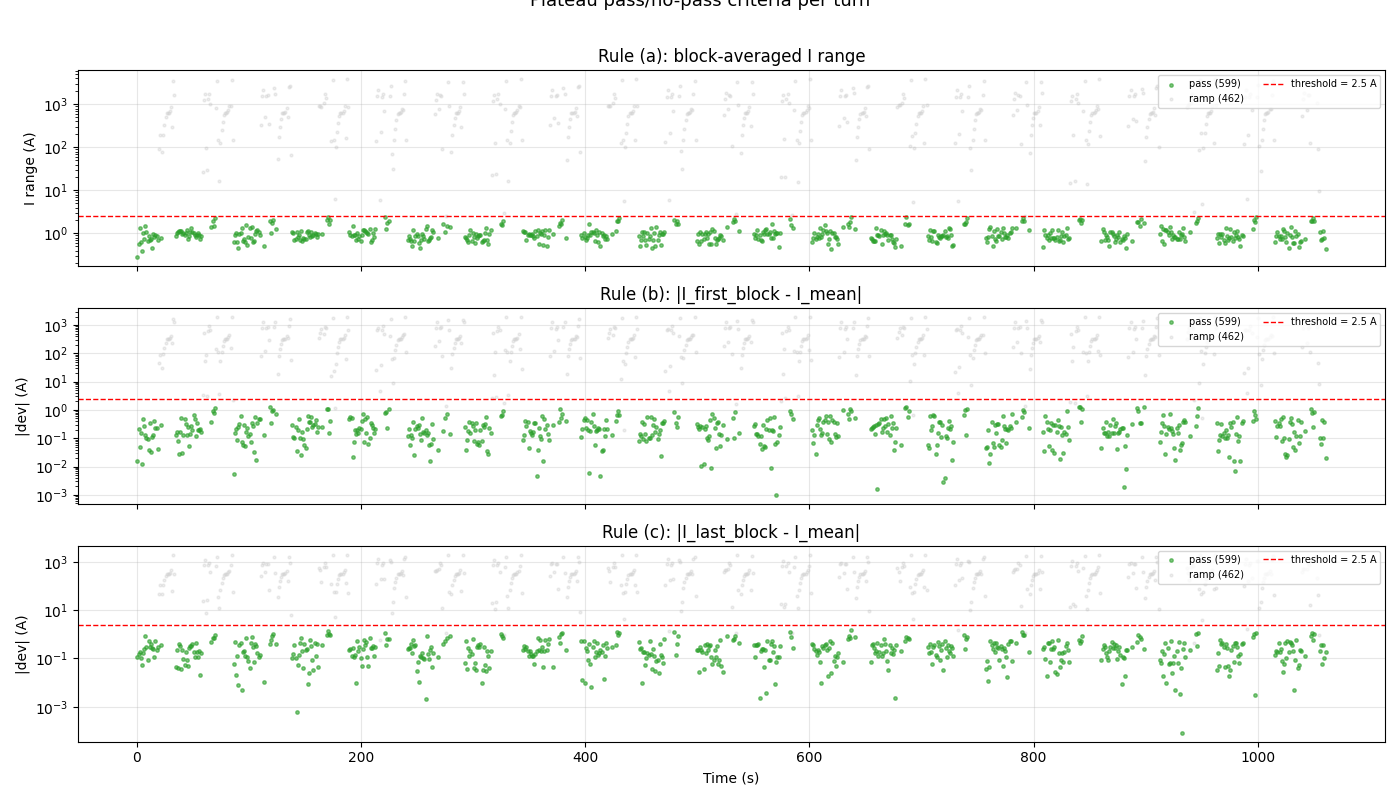


Turn classification:
  zero        :    25 turns, I =      0.0 +/-    0.1 A
  pre-ramp    :    12 turns, I =    160.9 +/-    0.1 A
  injection   :   488 turns, I =    300.9 +/-    0.2 A
  flat-high   :    74 turns, I =   4814.5 +/-    1.8 A
  ramp        :   462 turns, I =   2147.5 +/- 1767.5 A

  boundary-rej :     0 turns (flat range but ramp at start/end)

Turns for harmonic analysis: 562 / 1061


In [100]:
# --- Turn boundary times ---
t_start = t_all[:, 0]    # time of first sample of each turn
t_end   = t_all[:, -1]   # time of last sample of each turn

# --- Step 1: classify each turn as plateau or ramp ---
plateau_info = detect_plateau_turns(I_blocks, I_mean, I_range, PLATEAU_I_RANGE_MAX)
is_plateau = plateau_info["is_plateau"]
is_boundary_rejected = plateau_info["is_boundary_rejected"]
range_ok = plateau_info["range_ok"]
start_ok = plateau_info["start_ok"]
end_ok = plateau_info["end_ok"]

n_boundary_rejected = int(is_boundary_rejected.sum())
print(f"Plateau detection: {is_plateau.sum()} turns accepted, "
      f"{n_boundary_rejected} boundary-rejected")

# --- Pass / no-pass rules summary ---
print(f"\n{'='*70}")
print(f"PASS / NO-PASS RULES  (threshold = {PLATEAU_I_RANGE_MAX} A)")
print(f"{'='*70}")
print(f"  Rule (a)  block-averaged I range < {PLATEAU_I_RANGE_MAX} A")
print(f"            current must be flat (noise-filtered peak-to-peak)")
print(f"            -> {range_ok.sum()} / {n_turns} turns pass")
print(f"  Rule (b)  |I_first_block - I_mean| < {PLATEAU_I_RANGE_MAX} A")
print(f"            turn must start on the plateau")
print(f"            -> {(range_ok & start_ok).sum()} / {range_ok.sum()} (of range-ok) pass")
print(f"  Rule (c)  |I_last_block - I_mean| < {PLATEAU_I_RANGE_MAX} A")
print(f"            turn must end on the plateau")
print(f"            -> {(range_ok & end_ok).sum()} / {range_ok.sum()} (of range-ok) pass")
print(f"  ALL THREE -> {is_plateau.sum()} plateau turns")
print(f"  Boundary-rejected (pass a, fail b or c): {n_boundary_rejected}")

# --- Diagnostic: show the three criteria values per turn ---
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

I_start_edge = I_blocks[:, 0]
I_end_edge   = I_blocks[:, -1]
dev_start = np.abs(I_start_edge - I_mean)
dev_end   = np.abs(I_end_edge   - I_mean)

for ax, vals, title, ylabel in [
    (axes[0], I_range,   "Rule (a): block-averaged I range",          "I range (A)"),
    (axes[1], dev_start, "Rule (b): |I_first_block - I_mean|",        "|dev| (A)"),
    (axes[2], dev_end,   "Rule (c): |I_last_block - I_mean|",         "|dev| (A)"),
]:
    # pass turns
    ax.scatter(t_mean[is_plateau], vals[is_plateau],
               s=6, color="tab:green", alpha=0.6, label=f"pass ({is_plateau.sum()})", zorder=2)
    # boundary-rejected
    if is_boundary_rejected.sum() > 0:
        ax.scatter(t_mean[is_boundary_rejected], vals[is_boundary_rejected],
                   s=20, color="tab:orange", marker="x", linewidths=1,
                   label=f"boundary-rej ({is_boundary_rejected.sum()})", zorder=3)
    # ramp (fail range)
    ramp_mask = ~range_ok
    ax.scatter(t_mean[ramp_mask], vals[ramp_mask],
               s=4, color="lightgrey", alpha=0.4, label=f"ramp ({ramp_mask.sum()})", zorder=1)
    ax.axhline(PLATEAU_I_RANGE_MAX, color="red", linestyle="--", linewidth=1,
               label=f"threshold = {PLATEAU_I_RANGE_MAX} A")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale("log")
    ax.legend(fontsize=7, loc="upper right", ncol=2)

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Plateau pass/no-pass criteria per turn", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# --- Step 2: cluster plateau turns by current level ---
turn_label = np.array(["ramp"] * n_turns, dtype=object)
for i in range(n_turns):
    if is_plateau[i]:
        turn_label[i] = classify_current(I_mean[i])

# Summary
label_counts = Counter(turn_label)
print("\nTurn classification:")
for label in ["zero", "pre-ramp", "injection", "flat-low", "flat-mid",
              "flat-high", "ramp"]:
    n = label_counts.get(label, 0)
    if n > 0:
        mask = turn_label == label
        I_vals = I_mean[mask]
        print(f"  {label:12s}: {n:5d} turns, "
              f"I = {I_vals.mean():8.1f} +/- {I_vals.std():6.1f} A")

print(f"\n  boundary-rej : {is_boundary_rejected.sum():5d} turns "
      f"(flat range but ramp at start/end)")

# Plateau turns suitable for harmonic analysis
analysis_labels = {"injection", "flat-mid", "flat-high"}
is_analysis = np.array([l in analysis_labels for l in turn_label])
print(f"\nTurns for harmonic analysis: {is_analysis.sum()} / {n_turns}")

In [101]:
# --- Step 3: identify the supercycle structure ---
# A supercycle = one injection plateau + the cycles that follow until
# the next injection plateau.

# Find contiguous injection groups
inj_mask = turn_label == "injection"
inj_groups = find_contiguous_groups(inj_mask, min_length=2)

print(f"Injection plateaus detected: {len(inj_groups)}")
if len(inj_groups) == 0:
    print("  WARNING: no injection plateaus found -- try raising PLATEAU_I_RANGE_MAX")

# Between consecutive injections, find flat-top groups
cycle_info = []
for gi in range(len(inj_groups)):
    inj_s, inj_e = inj_groups[gi]

    # Look at turns AFTER this injection (until next injection)
    if gi + 1 < len(inj_groups):
        next_inj_s = inj_groups[gi + 1][0]
    else:
        next_inj_s = n_turns

    # Find flat-top turns in the gap between injections
    gap_slice = slice(inj_e + 1, next_inj_s)
    gap_labels = turn_label[gap_slice]
    gap_I = I_mean[gap_slice]
    gap_t = t_mean[gap_slice]
    gap_indices = np.arange(inj_e + 1, next_inj_s)

    # Find flat-high turns in this gap
    fh_mask = gap_labels == "flat-high"
    fm_mask = gap_labels == "flat-mid"

    peak_I = gap_I.max() if len(gap_I) > 0 else 0

    cycle_type = "unknown"
    if fh_mask.sum() >= 2:
        cycle_type = "flat-high"
    elif fm_mask.sum() >= 2:
        cycle_type = "flat-mid"
    elif peak_I > 5000:
        cycle_type = "fast-ramp-high"  # ramps high but no detectable flat top
    elif peak_I > 3000:
        cycle_type = "fast-ramp-mid"

    # Record flat-top turn indices for averaging
    ft_indices = []
    ft_label = None
    if fh_mask.sum() > 0:
        ft_indices.extend(gap_indices[fh_mask].tolist())
        ft_label = "flat-high"
    if fm_mask.sum() > 0:
        ft_indices.extend(gap_indices[fm_mask].tolist())
        if ft_label is None:
            ft_label = "flat-mid"

    cycle_info.append({
        "inj_start": inj_s,
        "inj_end": inj_e,
        "inj_turns": inj_e - inj_s + 1,
        "gap_start": inj_e + 1,
        "gap_end": next_inj_s - 1,
        "peak_I": peak_I,
        "cycle_type": cycle_type,
        "ft_indices": ft_indices,
        "ft_label": ft_label,
        "n_ft_turns": len(ft_indices),
    })

if cycle_info:
    df_cycles = pd.DataFrame(cycle_info)

    print(f"\nCycles between injection plateaus: {len(df_cycles)}")
    print(f"\nCycle type summary:")
    for ct in ["flat-high", "flat-mid", "fast-ramp-high", "fast-ramp-mid", "unknown"]:
        sub = df_cycles[df_cycles["cycle_type"] == ct]
        if len(sub) > 0:
            print(f"  {ct:18s}: {len(sub):3d} cycles, "
                  f"peak I = {sub['peak_I'].mean():.0f} +/- {sub['peak_I'].std():.0f} A, "
                  f"flat-top turns/cycle = {sub['n_ft_turns'].mean():.1f}")

    # Flat-top statistics
    for lab in ["flat-high", "flat-mid"]:
        all_ft = []
        for _, row in df_cycles.iterrows():
            if row["ft_label"] == lab:
                all_ft.extend(row["ft_indices"])
        if all_ft:
            ft_arr = np.array(all_ft)
            print(f"\n{lab}: {len(ft_arr)} total flat-top turns, "
                  f"I = {I_mean[ft_arr].mean():.1f} +/- {I_mean[ft_arr].std():.1f} A")
else:
    df_cycles = pd.DataFrame()
    print("\nNo cycles detected (no injection plateaus found).")

Injection plateaus detected: 20

Cycles between injection plateaus: 20

Cycle type summary:
  flat-high         :  20 cycles, peak I = 5593 +/- 206 A, flat-top turns/cycle = 3.7

flat-high: 74 total flat-top turns, I = 4814.5 +/- 1.8 A


SUPERCYCLE STRUCTURE  (LHC_pilot -> MD1 -> SFTPRO)
  Supercycles detected: 20

  MD1 injection (26 GeV, ~301 A):
    20 plateaus, 24.0 +/- 0.0 turns/SC

  SFTPRO flat-top (400 GeV, ~4815 A):
    74 total turns, 3.7 +/- 0.5 turns/SC, I = 4814.5 +/- 1.8 A

  LHC peak (450 GeV, ramp only):
    peak I = 5593 +/- 201 A (no stable flat-top detected)

 SC    MD1 inj  MD1 N  SFTPRO ft  SFT N  LHC pk(A)
--------------------------------------------------
  0      300.9     24     4814.4      4       5618
  1      300.9     24     4814.9      4       5626
  2      300.9     24     4814.1      4       5747
  3      300.9     24     4814.7      4       5487
  4      300.9     24     4815.2      3       5717
  5      300.9     24     4813.4      3       5629
  6      300.9     24     4815.0      4       5621
  7      300.9     24     4814.1      4       5749
  8      300.9     24     4814.6      4       5479
  9      300.9     24     4814.4      3       5713
 10      300.9     24     4814.0      3  

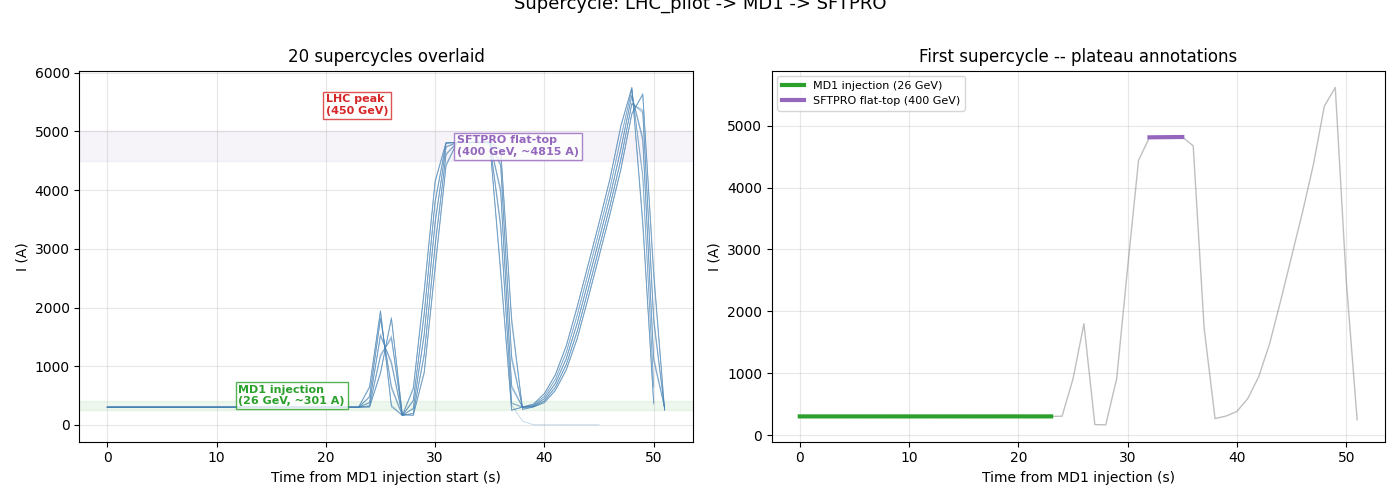

In [102]:
# =====================================================================
# 10b  Supercycle structure identification
# =====================================================================
# Detect supercycle boundaries and classify plateau roles (MD1, SFTPRO, etc.)
# The detected injection groups are the MD1 long injection plateaus (~25 turns
# at 301 A).  The "flat-high" turns between them are the SFTPRO flat-tops
# (~4 turns at 4815 A).  The LHC peak (~5700 A) appears as the max current
# in the gap between MD1 injections but has no stable flat-top.
#
# Supercycle order: LHC_pilot -> MD1 -> SFTPRO

if cycle_info:
    # Each cycle_info[gi] already has the right structure:
    #   inj_start..inj_end  = MD1 injection plateau
    #   ft_indices          = SFTPRO flat-top turns (in the gap after MD1)
    #   peak_I              = LHC peak current (in the gap after MD1)

    print("=" * 70)
    print("SUPERCYCLE STRUCTURE  (LHC_pilot -> MD1 -> SFTPRO)")
    print("=" * 70)
    print(f"  Supercycles detected: {len(cycle_info)}")

    md1_n = [ci["inj_turns"] for ci in cycle_info]
    sft_n = [ci["n_ft_turns"] for ci in cycle_info]
    lhc_pk = [ci["peak_I"] for ci in cycle_info]

    print(f"\n  MD1 injection (26 GeV, ~301 A):")
    print(f"    {len(inj_groups)} plateaus, "
          f"{np.mean(md1_n):.1f} +/- {np.std(md1_n):.1f} turns/SC")

    all_sft = []
    for ci in cycle_info:
        all_sft.extend(ci["ft_indices"])
    if all_sft:
        print(f"\n  SFTPRO flat-top (400 GeV, ~4815 A):")
        print(f"    {len(all_sft)} total turns, "
              f"{np.mean(sft_n):.1f} +/- {np.std(sft_n):.1f} turns/SC, "
              f"I = {I_mean[all_sft].mean():.1f} +/- {I_mean[all_sft].std():.1f} A")

    print(f"\n  LHC peak (450 GeV, ramp only):")
    print(f"    peak I = {np.mean(lhc_pk):.0f} +/- {np.std(lhc_pk):.0f} A "
          f"(no stable flat-top detected)")

    # Per-supercycle detail
    print(f"\n{'SC':>3s} {'MD1 inj':>10s} {'MD1 N':>6s} "
          f"{'SFTPRO ft':>10s} {'SFT N':>6s} {'LHC pk(A)':>10s}")
    print("-" * 50)
    for gi, ci in enumerate(cycle_info):
        md1_I = I_mean[ci["inj_start"]:ci["inj_end"] + 1].mean()
        sft_I = (I_mean[ci["ft_indices"]].mean()
                 if ci["ft_indices"] else 0)
        print(f"{gi:3d} {md1_I:10.1f} {ci['inj_turns']:6d} "
              f"{sft_I:10.1f} {ci['n_ft_turns']:6d} {ci['peak_I']:10.0f}")

    # --- Plots ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # (a) All supercycles overlaid, aligned at MD1 injection start
    ax = axes[0]
    for gi, ci in enumerate(cycle_info):
        idx_s = ci["inj_start"]
        idx_e = ci["gap_end"]
        t_offset = t_mean[idx_s]
        idx = np.arange(idx_s, min(idx_e + 1, n_turns))
        ax.plot(t_mean[idx] - t_offset, I_mean[idx],
                linewidth=0.6, alpha=0.35, color="steelblue")
    # Annotate phases on top of the overlay
    ax.axhspan(250, 400, alpha=0.08, color="tab:green")
    ax.axhspan(4500, 5000, alpha=0.08, color="tab:purple")
    ax.text(12, 350, "MD1 injection\n(26 GeV, ~301 A)", fontsize=8,
            color="tab:green", fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="tab:green", pad=2))
    ax.text(32, 4600, "SFTPRO flat-top\n(400 GeV, ~4815 A)", fontsize=8,
            color="tab:purple", fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="tab:purple", pad=2))
    ax.text(20, 5300, "LHC peak\n(450 GeV)", fontsize=8,
            color="tab:red", fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="tab:red", pad=2))
    ax.set_xlabel("Time from MD1 injection start (s)")
    ax.set_ylabel("I (A)")
    ax.set_title(f"{len(cycle_info)} supercycles overlaid")

    # (b) First supercycle with plateau annotations
    ax = axes[1]
    ci0 = cycle_info[0]
    idx_s = ci0["inj_start"]
    idx_e = ci0["gap_end"]
    t_off = t_mean[idx_s]
    idx = np.arange(idx_s, min(idx_e + 1, n_turns))
    ax.plot(t_mean[idx] - t_off, I_mean[idx],
            linewidth=1, color="grey", alpha=0.5)

    # Highlight MD1 injection
    inj_idx = np.arange(ci0["inj_start"], ci0["inj_end"] + 1)
    ax.plot(t_mean[inj_idx] - t_off, I_mean[inj_idx],
            linewidth=3, color="tab:green", label="MD1 injection (26 GeV)")

    # Highlight SFTPRO flat-top
    if ci0["ft_indices"]:
        ft_idx = np.array(ci0["ft_indices"])
        ax.plot(t_mean[ft_idx] - t_off, I_mean[ft_idx],
                linewidth=3, color="tab:purple", label="SFTPRO flat-top (400 GeV)")

    ax.set_xlabel("Time from MD1 injection (s)")
    ax.set_ylabel("I (A)")
    ax.set_title("First supercycle -- plateau annotations")
    ax.legend(fontsize=8)

    fig.suptitle("Supercycle: LHC_pilot -> MD1 -> SFTPRO",
                 fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No supercycles detected.")

---
## 5. Raw Signals with Plateau Annotations

C:\Users\albellel\AppData\Local\Temp\ipykernel_13296\3547888031.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


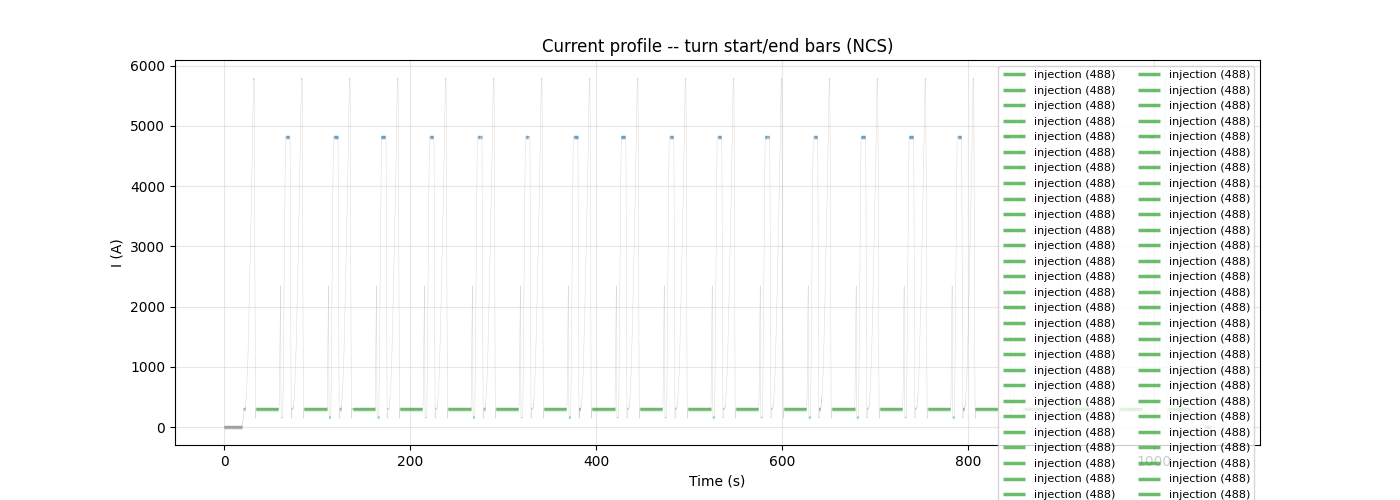

C:\Users\albellel\AppData\Local\Temp\ipykernel_13296\3547888031.py:91: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


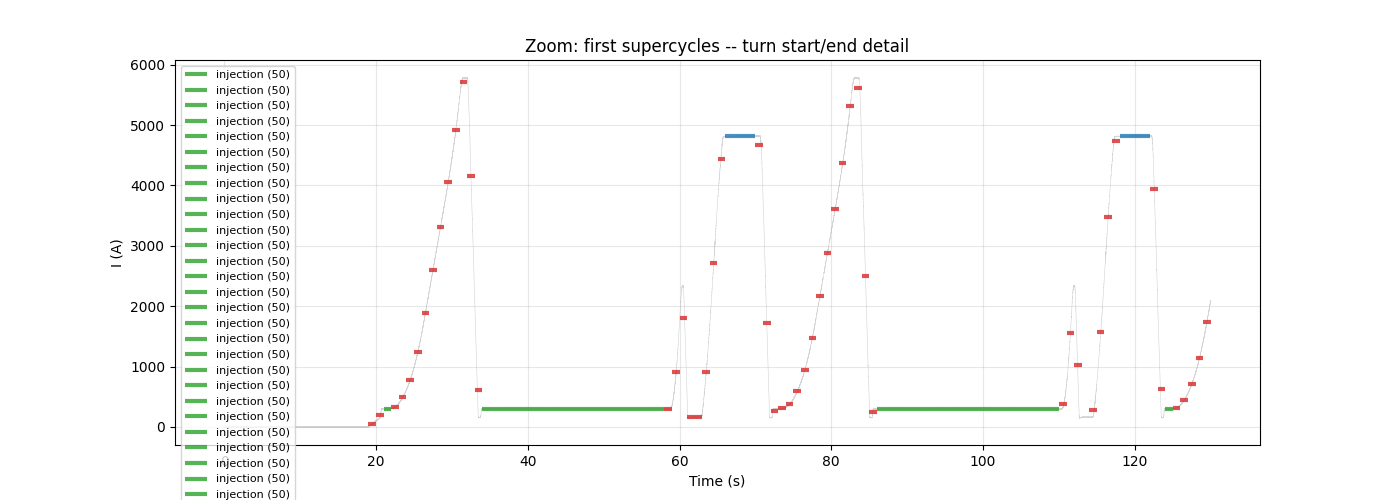

In [103]:
# --- Colors for turn classification ---
colors = {
    "injection": "tab:green",
    "flat-high": "tab:blue",
    "flat-mid": "tab:purple",
    "zero": "grey",
    "pre-ramp": "tab:cyan",
    "flat-low": "tab:olive",
    "ramp": "tab:red",
}

# =========================================================================
# Plot 1: Full view -- sample-level current with turn start/end bars
# =========================================================================
fig, ax = plt.subplots(figsize=(14, 5))

# Background: sample-level current (subsampled for speed)
step = max(1, n_keep // 80000)
ax.plot(raw[:n_keep:step, 0], raw[:n_keep:step, COL_I],
        linewidth=0.3, color="lightgrey", zorder=0)

# Draw each plateau turn as a horizontal bar from t_start to t_end
drawn_labels = set()
for label in ["injection", "flat-high", "flat-mid", "zero", "pre-ramp"]:
    mask = turn_label == label
    idx = np.where(mask)[0]
    if len(idx) == 0:
        continue
    col = colors[label]
    for j, ti in enumerate(idx):
        kw = dict(label=f"{label} ({len(idx)})") if label not in drawn_labels else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=2.5, color=col, alpha=0.7, solid_capstyle="butt",
                zorder=2, **kw)
    drawn_labels.add(label)

# Boundary-rejected turns as dashed bars
br_idx = np.where(is_boundary_rejected)[0]
if len(br_idx) > 0:
    for j, ti in enumerate(br_idx):
        kw = dict(label=f"boundary-rej ({len(br_idx)})") if j == 0 else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=2.5, color="red", alpha=0.6, linestyle="--",
                solid_capstyle="butt", zorder=3, **kw)

ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
ax.set_title(f"Current profile -- turn start/end bars ({SEGMENT})")
ax.legend(loc="upper right", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# =========================================================================
# Plot 2: Zoom -- first ~2 supercycles, turn bars visible
# =========================================================================
fig, ax = plt.subplots(figsize=(14, 5))

# Zoom time window
t_zoom_max = 130  # seconds
zoom_samp = raw[:n_keep, 0] < t_zoom_max
ax.plot(raw[:n_keep, 0][zoom_samp], raw[:n_keep, COL_I][zoom_samp],
        linewidth=0.4, color="lightgrey", zorder=0)

drawn_labels = set()
for label in ["injection", "flat-high", "flat-mid", "ramp"]:
    mask = (turn_label == label) & (t_mean < t_zoom_max)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        continue
    col = colors[label]
    for j, ti in enumerate(idx):
        kw = dict(label=f"{label} ({len(idx)})") if label not in drawn_labels else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=3, color=col, alpha=0.8, solid_capstyle="butt",
                zorder=2, **kw)
    drawn_labels.add(label)

# Boundary-rejected in zoom
br_zoom_idx = np.where(is_boundary_rejected & (t_mean < t_zoom_max))[0]
if len(br_zoom_idx) > 0:
    for j, ti in enumerate(br_zoom_idx):
        kw = dict(label=f"boundary-rej ({len(br_zoom_idx)})") if j == 0 else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=3, color="red", alpha=0.7, linestyle="--",
                solid_capstyle="butt", zorder=3, **kw)

ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
ax.set_title("Zoom: first supercycles -- turn start/end detail")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

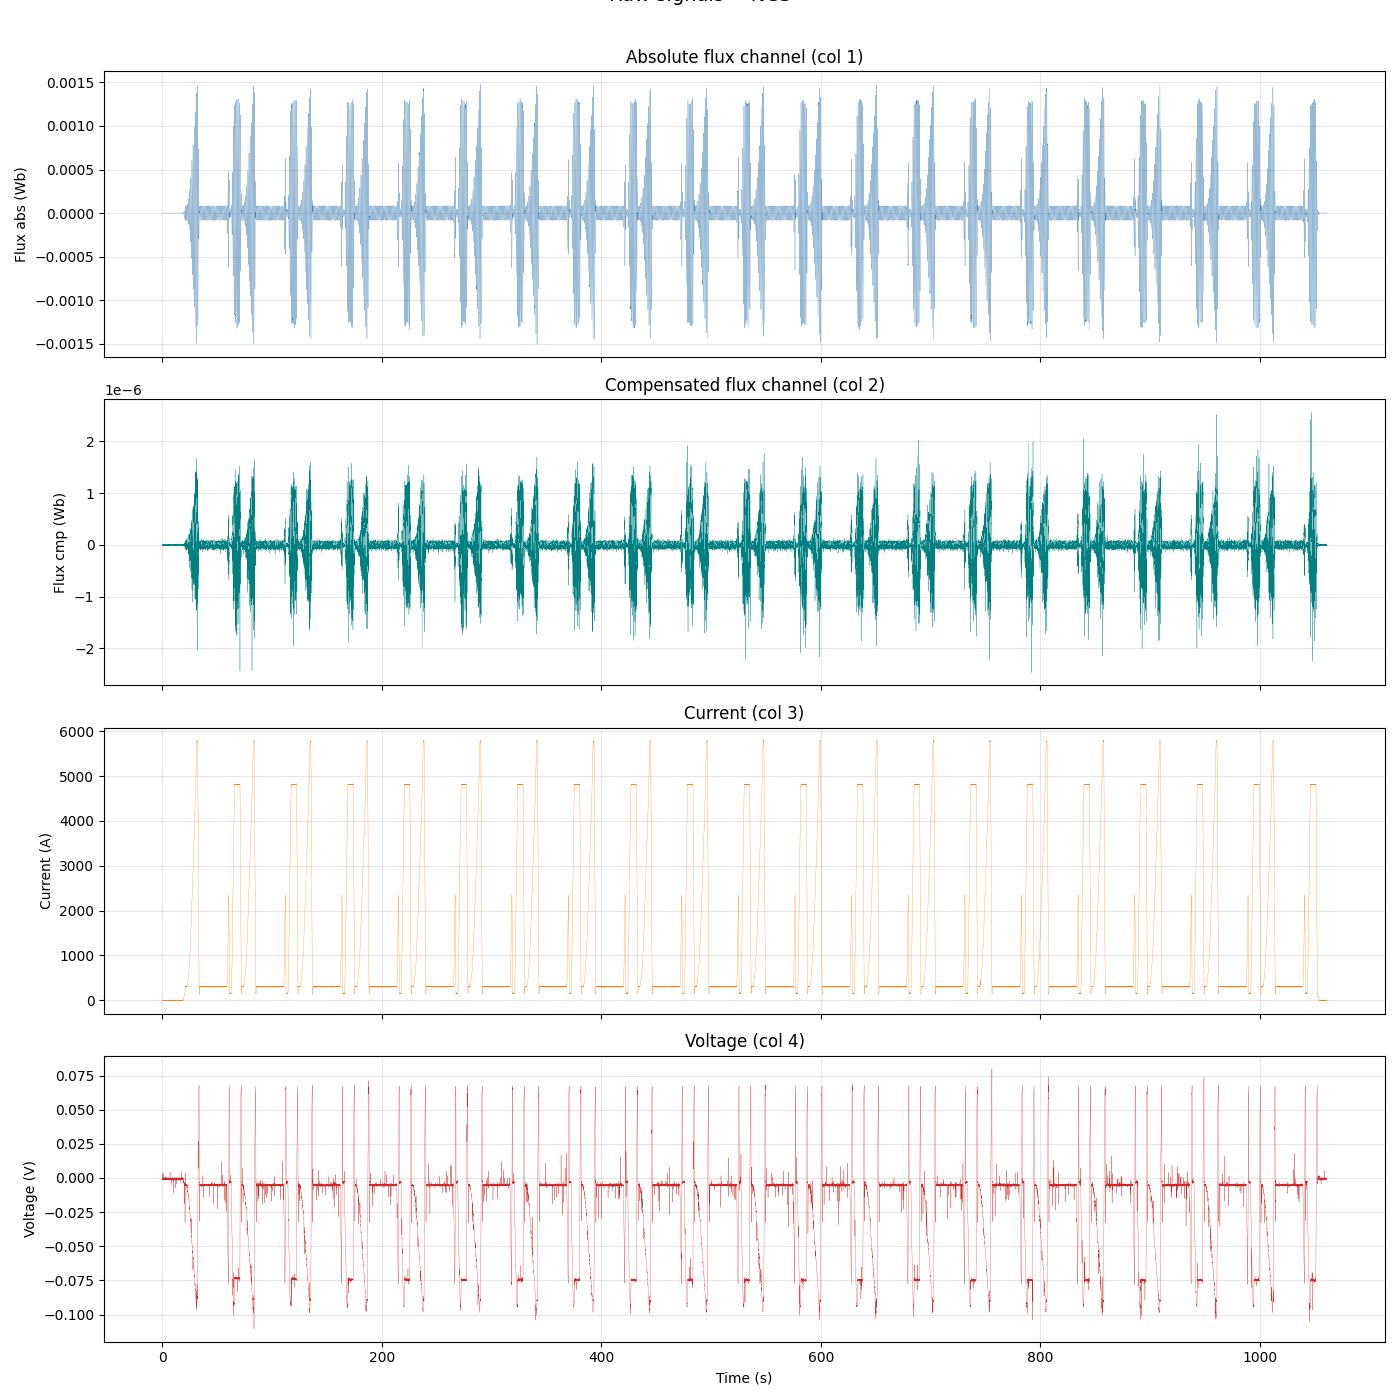

In [104]:
# Time series of all raw signals
has_voltage = V_all is not None
n_plots = 4 if has_voltage else 3
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3.5 * n_plots), sharex=True)

# Concatenated sample-level view (subsample for speed)
step = max(1, n_keep // 50000)
x = raw[:n_keep:step, 0]

ax = axes[0]
ax.plot(x, raw[:n_keep:step, COL_ABS], linewidth=0.2, color="steelblue")
ax.set_ylabel("Flux abs (Wb)")
ax.set_title(f"Absolute flux channel (col {COL_ABS})")

ax = axes[1]
ax.plot(x, raw[:n_keep:step, COL_CMP], linewidth=0.2, color="teal")
ax.set_ylabel("Flux cmp (Wb)")
ax.set_title(f"Compensated flux channel (col {COL_CMP})")

ax = axes[2]
ax.plot(x, raw[:n_keep:step, COL_I], linewidth=0.2, color="tab:orange")
ax.set_ylabel("Current (A)")
ax.set_title(f"Current (col {COL_I})")

if has_voltage:
    ax = axes[3]
    ax.plot(x, raw[:n_keep:step, COL_V], linewidth=0.2, color="tab:red")
    ax.set_ylabel("Voltage (V)")
    ax.set_title(f"Voltage (col {COL_V})")

axes[-1].set_xlabel("Time (s)")
fig.suptitle(f"Raw signals -- {SEGMENT}", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---
## 6. Pipeline Processing (Plateau Turns Only)

Only turns classified as **injection**, **flat-high**, or **flat-mid**
are processed through the harmonic pipeline.  Ramp turns are excluded.

In [105]:
m = MAGNET_ORDER
MAX_ZR = 0.01

def process_turns(turn_indices, drift_mode="legacy"):
    '''Process selected turns through the Kn pipeline.'''
    idx = np.array(turn_indices)
    n = len(idx)
    if n == 0:
        return []

    result, C_merged, C_units, ok_main = process_kn_pipeline(
        flux_abs_turns=flux_abs_all[idx],
        flux_cmp_turns=flux_cmp_all[idx],
        t_turns=t_all[idx],
        I_turns=I_all[idx],
        kn=kn,
        r_ref=R_REF,
        magnet_order=m,
        options=OPTIONS,
        drift_mode=drift_mode,
        min_b1_T=MIN_B1_T,
        max_zr=MAX_ZR,
    )

    # Build extra columns specific to this notebook
    extra = [
        {
            "global_turn": int(idx[t]),
            "I_range_A": float(I_range[idx[t]]),
            "label": str(turn_label[idx[t]]),
        }
        for t in range(n)
    ]

    return build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)

# Collect all plateau turn indices
plateau_indices = np.where(is_analysis)[0]
print(f"Processing {len(plateau_indices)} plateau turns (of {n_turns} total)...")

if len(plateau_indices) == 0:
    print("\nWARNING: no plateau turns to process!")
    print(f"  Try raising PLATEAU_I_RANGE_MAX (currently {PLATEAU_I_RANGE_MAX} A)")
    df_L = pd.DataFrame()
    df_W = pd.DataFrame()
else:
    rows_L = process_turns(plateau_indices, "legacy")
    rows_W = process_turns(plateau_indices, "weighted")

    df_L = pd.DataFrame(rows_L)
    df_W = pd.DataFrame(rows_W)

    print(f"\nProcessed: {len(df_L)} turns")
    for lab in sorted(df_L["label"].unique()):
        sub = df_L[df_L["label"] == lab]
        print(f"  {lab:12s}: {len(sub):5d} turns, "
              f"I = {sub['I_mean_A'].mean():.1f} +/- {sub['I_mean_A'].std():.1f} A, "
              f"ok_main: {sub['ok_main'].sum()}/{len(sub)}")

Processing 562 plateau turns (of 1061 total)...

Processed: 562 turns
  flat-high   :    74 turns, I = 4814.5 +/- 1.9 A, ok_main: 74/74
  injection   :   488 turns, I = 300.9 +/- 0.2 A, ok_main: 488/488


In [106]:
# =====================================================================
# 10c  Tag turns with supercycle metadata
# =====================================================================
# Assign supercycle_idx, plateau_role, and turn_in_plateau to each turn.

if len(df_L) > 0 and cycle_info:
    turn_cycle_map = {}
    for gi, ci in enumerate(cycle_info):
        # MD1 injection plateau turns
        for ti in range(ci["inj_start"], ci["inj_end"] + 1):
            turn_cycle_map[ti] = {
                "supercycle_idx": gi,
                "plateau_role": "md1-injection",
                "turn_in_plateau": ti - ci["inj_start"],
            }
        # SFTPRO flat-top turns (sorted to get correct position)
        for j, ti in enumerate(sorted(ci["ft_indices"])):
            turn_cycle_map[ti] = {
                "supercycle_idx": gi,
                "plateau_role": "sftpro-flattop",
                "turn_in_plateau": j,
            }

    for df in [df_L, df_W]:
        df["supercycle_idx"] = df["global_turn"].map(
            lambda t: turn_cycle_map.get(t, {}).get("supercycle_idx", -1))
        df["plateau_role"] = df["global_turn"].map(
            lambda t: turn_cycle_map.get(t, {}).get("plateau_role", "other"))
        df["turn_in_plateau"] = df["global_turn"].map(
            lambda t: turn_cycle_map.get(t, {}).get("turn_in_plateau", -1))

    print("Cycle metadata added to dataframes.")
    for role in ["md1-injection", "sftpro-flattop"]:
        sub = df_L[df_L["plateau_role"] == role]
        if len(sub) > 0:
            n_sc = sub["supercycle_idx"].nunique()
            tc = sub.groupby("supercycle_idx").size()
            print(f"  {role:20s}: {len(sub):4d} turns across {n_sc} supercycles "
                  f"({tc.min()}-{tc.max()} turns/SC, mean {tc.mean():.1f})")

    # Check for untagged turns
    other = df_L[df_L["plateau_role"] == "other"]
    if len(other) > 0:
        print(f"  {'other (untagged)':20s}: {len(other):4d} turns "
              f"(likely ramp boundary turns)")
else:
    print("No turns to tag.")

Cycle metadata added to dataframes.
  md1-injection       :  480 turns across 20 supercycles (24-24 turns/SC, mean 24.0)
  sftpro-flattop      :   74 turns across 20 supercycles (3-4 turns/SC, mean 3.7)
  other (untagged)    :    8 turns (likely ramp boundary turns)


---
## 7. Main Field (B1) per Plateau

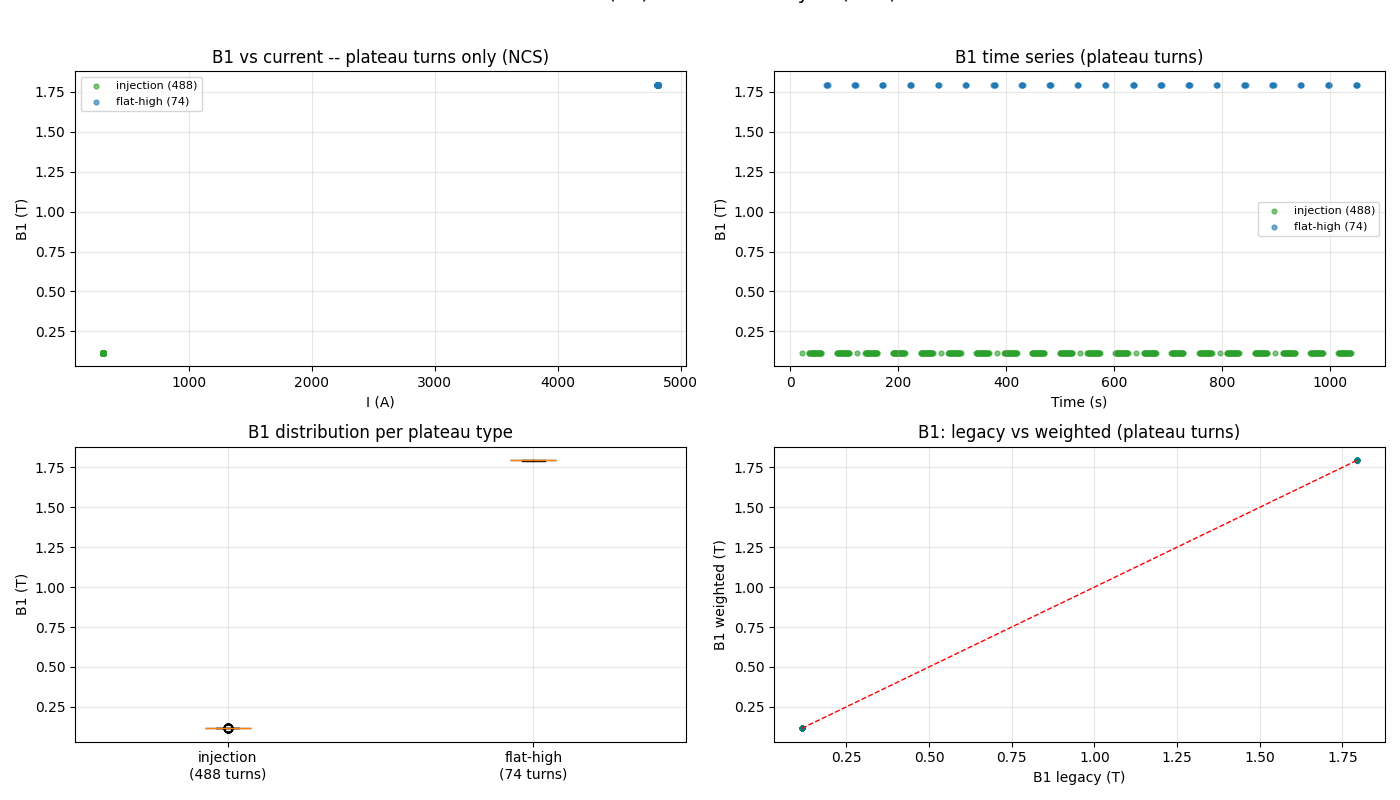


B1 per plateau type (legacy, ok_main only):
     Plateau     N    B1 mean (T)   B1 std (T)   I mean (A)
------------------------------------------------------------
   injection   488      +0.115640     0.000066        300.9
   flat-high    74      +1.793702     0.000480       4814.5


In [107]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    label_colors = {"injection": "tab:green", "flat-high": "tab:blue", "flat-mid": "tab:purple"}
    
    # (a) B1 vs I, coloured by plateau type
    ax = axes[0, 0]
    for lab, col in label_colors.items():
        mask = df_L["label"] == lab
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "I_mean_A"], df_L.loc[mask, "B1_T"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.set_xlabel("I (A)")
    ax.set_ylabel("B1 (T)")
    ax.set_title(f"B1 vs current -- plateau turns only ({SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) B1 time series
    ax = axes[0, 1]
    for lab, col in label_colors.items():
        mask = df_L["label"] == lab
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "time_s"], df_L.loc[mask, "B1_T"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("B1 (T)")
    ax.set_title("B1 time series (plateau turns)")
    ax.legend(fontsize=8)
    
    # (c) B1 per plateau type: box plot
    ax = axes[1, 0]
    box_data = []
    box_labels_list = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & df_L["ok_main"]
        vals = df_L.loc[mask, "B1_T"].values
        if len(vals) > 0:
            box_data.append(vals)
            box_labels_list.append(f"{lab}\n({len(vals)} turns)")
    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels_list, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("B1 (T)")
    ax.set_title("B1 distribution per plateau type")
    
    # (d) B1 legacy vs weighted
    ax = axes[1, 1]
    ok = df_L["ok_main"].values
    ax.scatter(df_L.loc[ok, "B1_T"], df_W.loc[ok, "B1_T"], s=8, alpha=0.5, c="teal")
    lims = [df_L.loc[ok, "B1_T"].min(), df_L.loc[ok, "B1_T"].max()]
    ax.plot(lims, lims, "r--", linewidth=1)
    ax.set_xlabel("B1 legacy (T)")
    ax.set_ylabel("B1 weighted (T)")
    ax.set_title("B1: legacy vs weighted (plateau turns)")
    
    fig.suptitle(f"Main Field (B1) -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Per-plateau-type statistics
    print("\nB1 per plateau type (legacy, ok_main only):")
    print(f"{'Plateau':>12s} {'N':>5s} {'B1 mean (T)':>14s} {'B1 std (T)':>12s} "
          f"{'I mean (A)':>12s}")
    print("-" * 60)
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & df_L["ok_main"]
        if mask.sum() == 0:
            continue
        B1 = df_L.loc[mask, "B1_T"].values
        I_v = df_L.loc[mask, "I_mean_A"].values
        print(f"{lab:>12s} {mask.sum():5d} {B1.mean():+14.6f} {B1.std():12.6f} "
              f"{I_v.mean():12.1f}")

---
## 8. Transfer Function B/I vs I

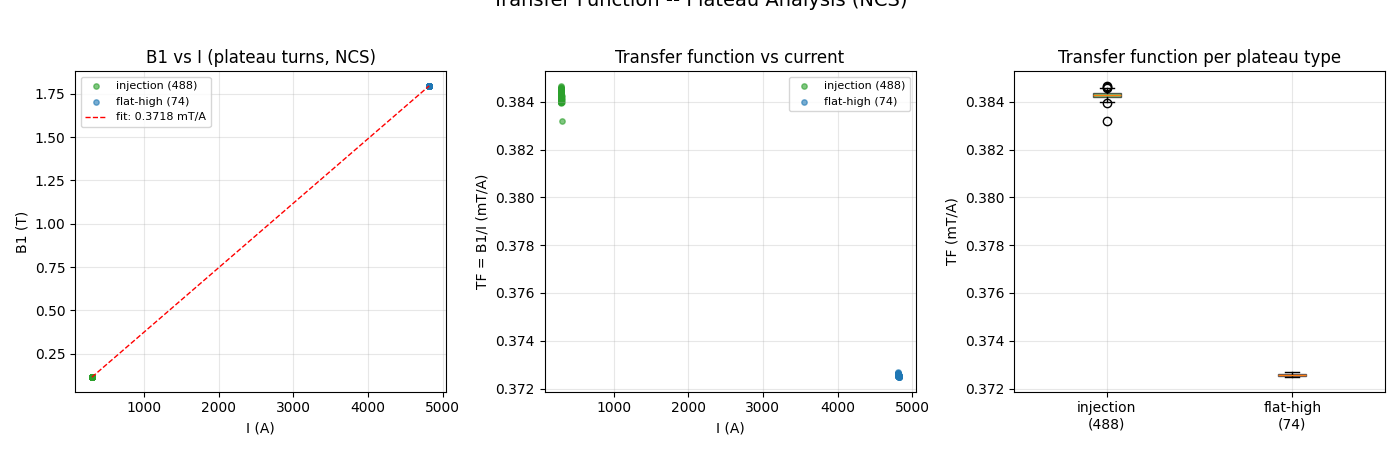


Transfer function per plateau type:
     Plateau     N   TF mean (mT/A)  TF std (mT/A)
----------------------------------------------------
   injection   488         0.384269       0.000125
   flat-high    74         0.372560       0.000045


In [108]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    ok_tf = df_L["ok_main"] & (df_L["I_mean_A"] > 50)
    I_tf = df_L.loc[ok_tf, "I_mean_A"].values
    B1_tf = df_L.loc[ok_tf, "B1_T"].values
    TF = B1_tf / I_tf  # T/A
    labels_tf = df_L.loc[ok_tf, "label"].values
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
    
    # (a) B1 vs I with linear fit
    ax = axes[0]
    for lab, col in label_colors.items():
        m_lab = labels_tf == lab
        if m_lab.sum() > 0:
            ax.scatter(I_tf[m_lab], B1_tf[m_lab], s=15, alpha=0.6, color=col,
                       label=f"{lab} ({m_lab.sum()})")
    if len(I_tf) > 2:
        coeffs = np.polyfit(I_tf, B1_tf, 1)
        I_fit = np.linspace(I_tf.min(), I_tf.max(), 100)
        ax.plot(I_fit, np.polyval(coeffs, I_fit), "r--", linewidth=1,
                label=f"fit: {coeffs[0]*1e3:.4f} mT/A")
    ax.set_xlabel("I (A)")
    ax.set_ylabel("B1 (T)")
    ax.set_title(f"B1 vs I (plateau turns, {SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) TF vs I
    ax = axes[1]
    for lab, col in label_colors.items():
        m_lab = labels_tf == lab
        if m_lab.sum() > 0:
            ax.scatter(I_tf[m_lab], TF[m_lab] * 1e3, s=15, alpha=0.6, color=col,
                       label=f"{lab} ({m_lab.sum()})")
    ax.set_xlabel("I (A)")
    ax.set_ylabel("TF = B1/I (mT/A)")
    ax.set_title("Transfer function vs current")
    ax.legend(fontsize=8)
    
    # (c) TF per plateau type
    ax = axes[2]
    tf_data = []
    tf_labels = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        m_lab = labels_tf == lab
        if m_lab.sum() > 0:
            tf_data.append(TF[m_lab] * 1e3)
            tf_labels.append(f"{lab}\n({m_lab.sum()})")
    if tf_data:
        bp = ax.boxplot(tf_data, tick_labels=tf_labels, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("TF (mT/A)")
    ax.set_title("Transfer function per plateau type")
    
    fig.suptitle(f"Transfer Function -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Table
    print("\nTransfer function per plateau type:")
    print(f"{'Plateau':>12s} {'N':>5s} {'TF mean (mT/A)':>16s} {'TF std (mT/A)':>14s}")
    print("-" * 52)
    for lab in ["injection", "flat-mid", "flat-high"]:
        m_lab = labels_tf == lab
        if m_lab.sum() == 0:
            continue
        tf_v = TF[m_lab] * 1e3
        print(f"{lab:>12s} {m_lab.sum():5d} {tf_v.mean():16.6f} {tf_v.std():14.6f}")

---
## 9. b2 (Quadrupole) per Plateau

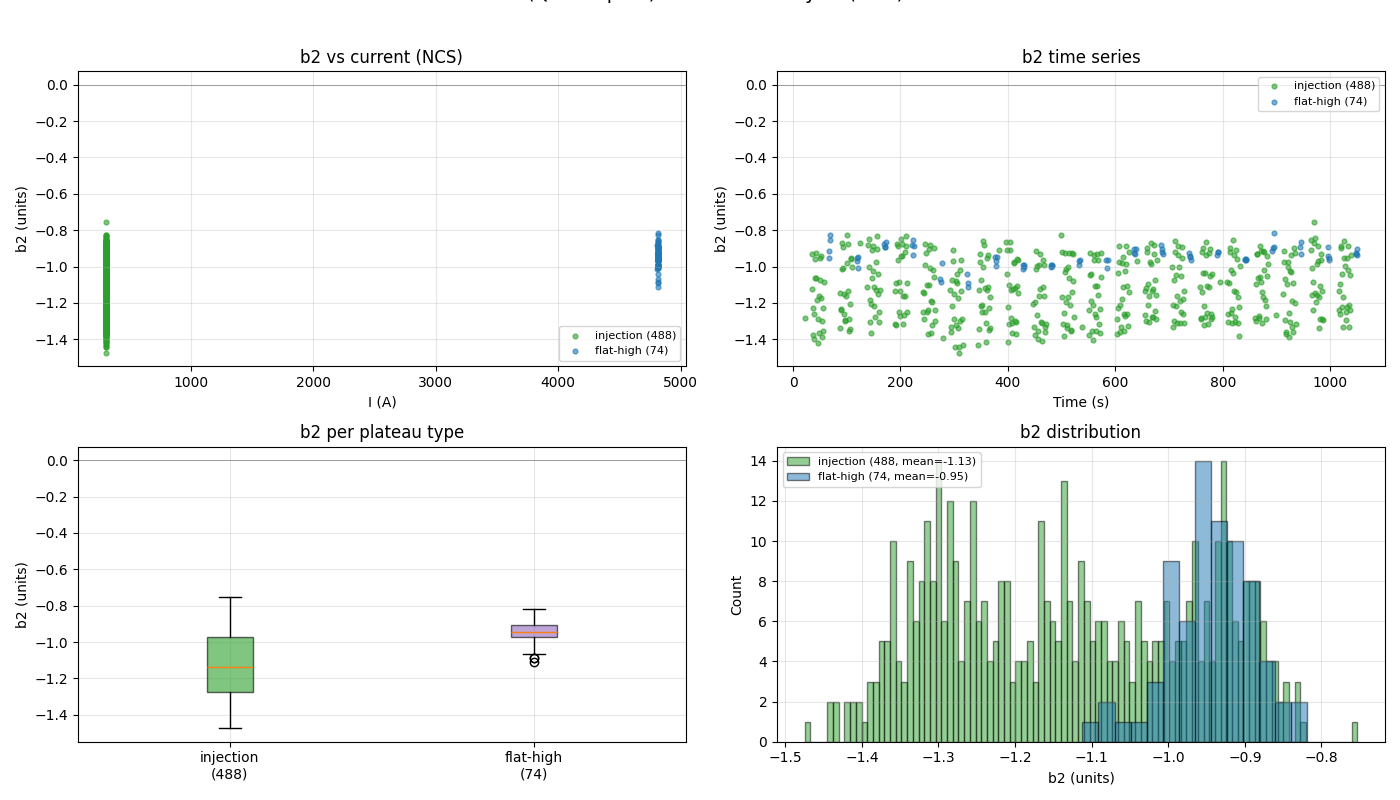


b2 per plateau type (legacy, ok_main):
     Plateau     N       mean        std     median
--------------------------------------------------
   injection   488    -1.1287     0.1644    -1.1367
   flat-high    74    -0.9453     0.0566    -0.9448


In [109]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    ok_norm = df_L["ok_main"].values
    
    # (a) b2 vs I
    ax = axes[0, 0]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "I_mean_A"], df_L.loc[mask, "b2_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("I (A)")
    ax.set_ylabel("b2 (units)")
    ax.set_title(f"b2 vs current ({SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) b2 time series
    ax = axes[0, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "time_s"], df_L.loc[mask, "b2_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b2 (units)")
    ax.set_title("b2 time series")
    ax.legend(fontsize=8)
    
    # (c) b2 box plot per plateau
    ax = axes[1, 0]
    box_data = []
    box_labels_list = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b2_units"])
        vals = df_L.loc[mask, "b2_units"].values
        if len(vals) > 0:
            box_data.append(vals)
            box_labels_list.append(f"{lab}\n({len(vals)})")
    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels_list, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("b2 (units)")
    ax.set_title("b2 per plateau type")
    ax.axhline(0, color="grey", linewidth=0.5)
    
    # (d) b2 histogram per plateau
    ax = axes[1, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b2_units"])
        vals = df_L.loc[mask, "b2_units"].values
        if len(vals) > 0:
            ax.hist(vals, bins=max(10, len(vals) // 5), alpha=0.5,
                    color=col, label=f"{lab} ({len(vals)}, mean={vals.mean():.2f})",
                    edgecolor="black")
    ax.set_xlabel("b2 (units)")
    ax.set_ylabel("Count")
    ax.set_title("b2 distribution")
    ax.legend(fontsize=8)
    
    fig.suptitle(f"b2 (Quadrupole) -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Table
    print("\nb2 per plateau type (legacy, ok_main):")
    print(f"{'Plateau':>12s} {'N':>5s} {'mean':>10s} {'std':>10s} {'median':>10s}")
    print("-" * 50)
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b2_units"])
        vals = df_L.loc[mask, "b2_units"].values
        if len(vals) == 0:
            continue
        print(f"{lab:>12s} {len(vals):5d} {vals.mean():+10.4f} "
              f"{vals.std():10.4f} {np.median(vals):+10.4f}")

---
## 10. b3 (Sextupole) per Plateau

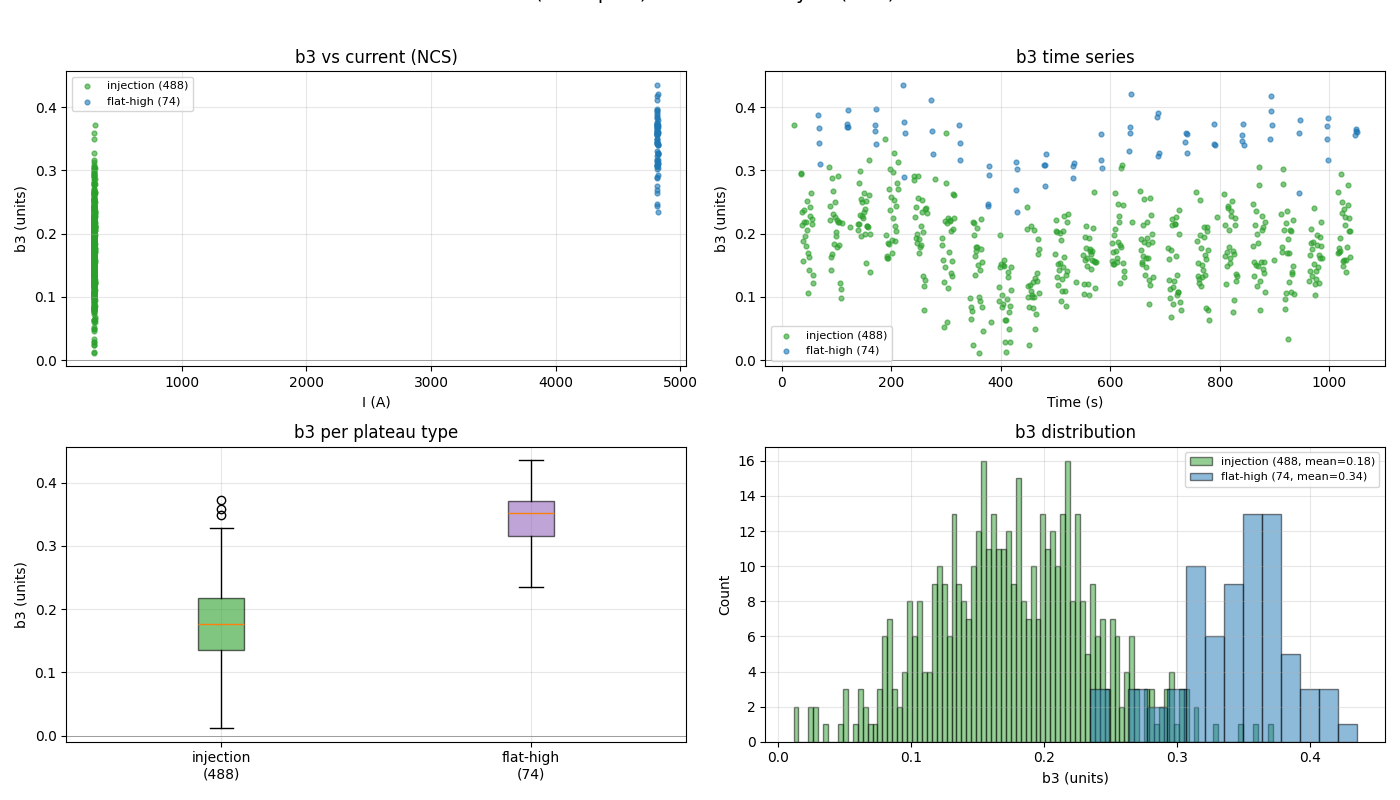


b3 per plateau type (legacy, ok_main):
     Plateau     N       mean        std     median
--------------------------------------------------
   injection   488    +0.1772     0.0611    +0.1761
   flat-high    74    +0.3439     0.0412    +0.3525


In [110]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # (a) b3 vs I
    ax = axes[0, 0]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "I_mean_A"], df_L.loc[mask, "b3_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("I (A)")
    ax.set_ylabel("b3 (units)")
    ax.set_title(f"b3 vs current ({SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) b3 time series
    ax = axes[0, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "time_s"], df_L.loc[mask, "b3_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b3 (units)")
    ax.set_title("b3 time series")
    ax.legend(fontsize=8)
    
    # (c) b3 box plot per plateau
    ax = axes[1, 0]
    box_data = []
    box_labels_list = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b3_units"])
        vals = df_L.loc[mask, "b3_units"].values
        if len(vals) > 0:
            box_data.append(vals)
            box_labels_list.append(f"{lab}\n({len(vals)})")
    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels_list, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("b3 (units)")
    ax.set_title("b3 per plateau type")
    ax.axhline(0, color="grey", linewidth=0.5)
    
    # (d) b3 histogram per plateau
    ax = axes[1, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b3_units"])
        vals = df_L.loc[mask, "b3_units"].values
        if len(vals) > 0:
            ax.hist(vals, bins=max(10, len(vals) // 5), alpha=0.5,
                    color=col, label=f"{lab} ({len(vals)}, mean={vals.mean():.2f})",
                    edgecolor="black")
    ax.set_xlabel("b3 (units)")
    ax.set_ylabel("Count")
    ax.set_title("b3 distribution")
    ax.legend(fontsize=8)
    
    fig.suptitle(f"b3 (Sextupole) -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Table
    print("\nb3 per plateau type (legacy, ok_main):")
    print(f"{'Plateau':>12s} {'N':>5s} {'mean':>10s} {'std':>10s} {'median':>10s}")
    print("-" * 50)
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b3_units"])
        vals = df_L.loc[mask, "b3_units"].values
        if len(vals) == 0:
            continue
        print(f"{lab:>12s} {len(vals):5d} {vals.mean():+10.4f} "
              f"{vals.std():10.4f} {np.median(vals):+10.4f}")

---
## 11. Hysteresis Analysis

Time evolution of B1, b2, b3 at each plateau over 20 supercycle repetitions.

The supercycle pattern is always **LHC_pilot -> MD1 -> SFTPRO**, so the
magnetic history preceding each plateau is the same for every repetition.
What changes is the **conditioning state** of the iron yoke as the magnet
approaches cyclic steady state.

- **MD1 injection** (~301 A, 26 GeV): long plateau (~25 turns) after the
  LHC cycle ramped to ~5785 A.  Remanent field from the LHC excitation is
  visible here.  The **current is rock-steady** (drift < 0.1 A over 24
  turns), making this a clean probe of iron-yoke hysteresis and
  eddy-current settling.
- **SFTPRO flat-top** (~4815 A, 400 GeV): short plateau (3-4 turns).
  **Caution**: the current is still **ramping** (+4.8 A over 4 turns), so
  B1 changes here track dI/dt, not eddy-current transients.  This is not
  a true flat-top at coil-turn time resolution.

MD1 injection -- current flatness check:
  I = 300.91 +/- 0.090 A  (p-p = 0.561 A)
  -> TRUE PLATEAU: current is rock-steady



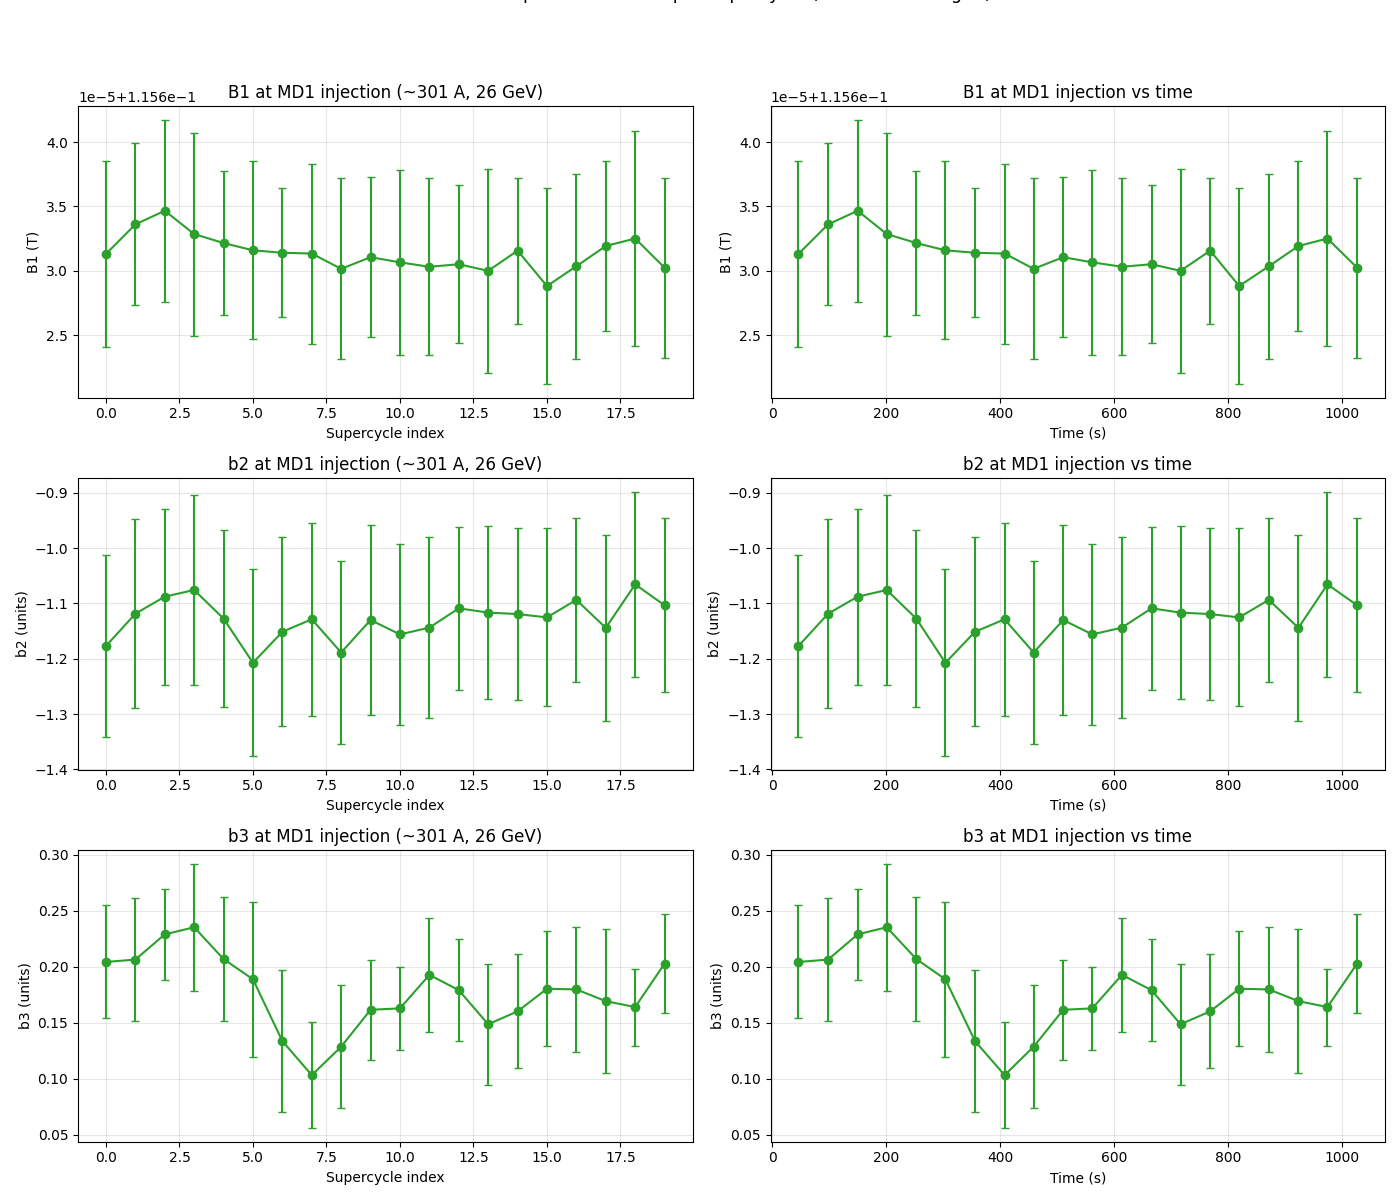


MD1 injection: per-supercycle summary (24 turns/SC averaged)
  SC     I(A)   I std          B1(T)      b2(u)      b3(u)    N
--------------------------------------------------------------
   0    300.9   0.091     +0.1156313    -1.1770    +0.2041   24
   1    300.9   0.118     +0.1156336    -1.1186    +0.2062   24
   2    300.9   0.093     +0.1156347    -1.0878    +0.2287   24
   3    300.9   0.089     +0.1156329    -1.0758    +0.2351   24
   4    300.9   0.077     +0.1156322    -1.1275    +0.2067   24
   5    300.9   0.078     +0.1156316    -1.2074    +0.1886   24
   6    300.9   0.091     +0.1156314    -1.1513    +0.1334   24
   7    300.9   0.086     +0.1156313    -1.1287    +0.1030   24
   8    300.9   0.080     +0.1156302    -1.1888    +0.1284   24
   9    300.9   0.077     +0.1156311    -1.1300    +0.1614   24
  10    300.9   0.110     +0.1156307    -1.1561    +0.1626   24
  11    300.9   0.080     +0.1156303    -1.1438    +0.1926   24
  12    300.9   0.096     +0.1156305    -1.

In [111]:
# =====================================================================
# 11a) MD1 injection plateau (~301 A) -- evolution over 20 supercycles
# =====================================================================
# TRUE CURRENT PLATEAU: I drift < 0.1 A over 24 turns.
# The MD1 injection comes right after the LHC cycle (peak ~5785 A).
# The remanent field in the iron yoke from the LHC excitation affects B1
# at this low-current plateau.  Tracking the evolution shows the magnet
# approaching cyclic steady state.

if len(df_L) > 0 and "supercycle_idx" in df_L.columns:
    ok = df_L["ok_main"].values
    md1_ok = (df_L["plateau_role"] == "md1-injection") & ok
    df_md1 = df_L[md1_ok].copy()

    if len(df_md1) == 0:
        print("No MD1 injection turns with ok_main -- skipping.")
    else:
        # Per-supercycle mean
        md1_sc = df_md1.groupby("supercycle_idx").agg(
            B1_mean=("B1_T", "mean"),
            B1_std=("B1_T", "std"),
            B1_count=("B1_T", "count"),
            b2_mean=("b2_units", "mean"),
            b2_std=("b2_units", "std"),
            b3_mean=("b3_units", "mean"),
            b3_std=("b3_units", "std"),
            I_mean=("I_mean_A", "mean"),
            I_std=("I_mean_A", "std"),
            t_mean=("time_s", "mean"),
        ).reset_index()

        # Current flatness check
        I_all = df_md1["I_mean_A"].values
        print(f"MD1 injection -- current flatness check:")
        print(f"  I = {I_all.mean():.2f} +/- {I_all.std():.3f} A  "
              f"(p-p = {I_all.max() - I_all.min():.3f} A)")
        print(f"  -> TRUE PLATEAU: current is rock-steady\n")

        fig, axes = plt.subplots(3, 2, figsize=(14, 12))

        for row, (name, col_m, col_s, unit) in enumerate([
            ("B1", "B1_mean", "B1_std", "T"),
            ("b2", "b2_mean", "b2_std", "units"),
            ("b3", "b3_mean", "b3_std", "units"),
        ]):
            # Left: vs supercycle index
            ax = axes[row, 0]
            ax.errorbar(
                md1_sc["supercycle_idx"], md1_sc[col_m],
                yerr=md1_sc[col_s].fillna(0),
                fmt="o-", color="tab:green", markersize=6, capsize=3,
            )
            ax.set_xlabel("Supercycle index")
            ax.set_ylabel(f"{name} ({unit})")
            ax.set_title(f"{name} at MD1 injection (~301 A, 26 GeV)")

            # Right: vs time
            ax = axes[row, 1]
            ax.errorbar(
                md1_sc["t_mean"], md1_sc[col_m],
                yerr=md1_sc[col_s].fillna(0),
                fmt="o-", color="tab:green", markersize=6, capsize=3,
            )
            ax.set_xlabel("Time (s)")
            ax.set_ylabel(f"{name} ({unit})")
            ax.set_title(f"{name} at MD1 injection vs time")

        fig.suptitle(
            "Hysteresis at MD1 injection (26 GeV, ~301 A)\n"
            "True current plateau -- mean per supercycle "
            "(24 turns averaged)",
            fontsize=13, y=1.03,
        )
        plt.tight_layout()
        plt.show()

        # Table
        print("\nMD1 injection: per-supercycle summary "
              "(24 turns/SC averaged)")
        print(f"{'SC':>4s} {'I(A)':>8s} {'I std':>7s} "
              f"{'B1(T)':>14s} {'b2(u)':>10s} {'b3(u)':>10s} {'N':>4s}")
        print("-" * 62)
        for _, r in md1_sc.iterrows():
            print(f"{int(r['supercycle_idx']):4d} {r['I_mean']:8.1f} "
                  f"{r['I_std']:7.3f} "
                  f"{r['B1_mean']:+14.7f} "
                  f"{r['b2_mean']:+10.4f} "
                  f"{r['b3_mean']:+10.4f} "
                  f"{int(r['B1_count']):4d}")
else:
    print("No data for hysteresis analysis.")

SFTPRO flat-top -- current flatness check:
  I = 4814.54 +/- 1.840 A  (p-p = 6.523 A)
  turn 0: I = 4812.31 +/- 0.487 A
  turn 1: I = 4813.86 +/- 0.497 A
  turn 2: I = 4815.63 +/- 0.799 A
  turn 3: I = 4817.14 +/- 0.389 A
  -> NOT A TRUE PLATEAU: current ramps +4.8 A over 3 turns
     B1 changes track the current ramp, not eddy-current settling.



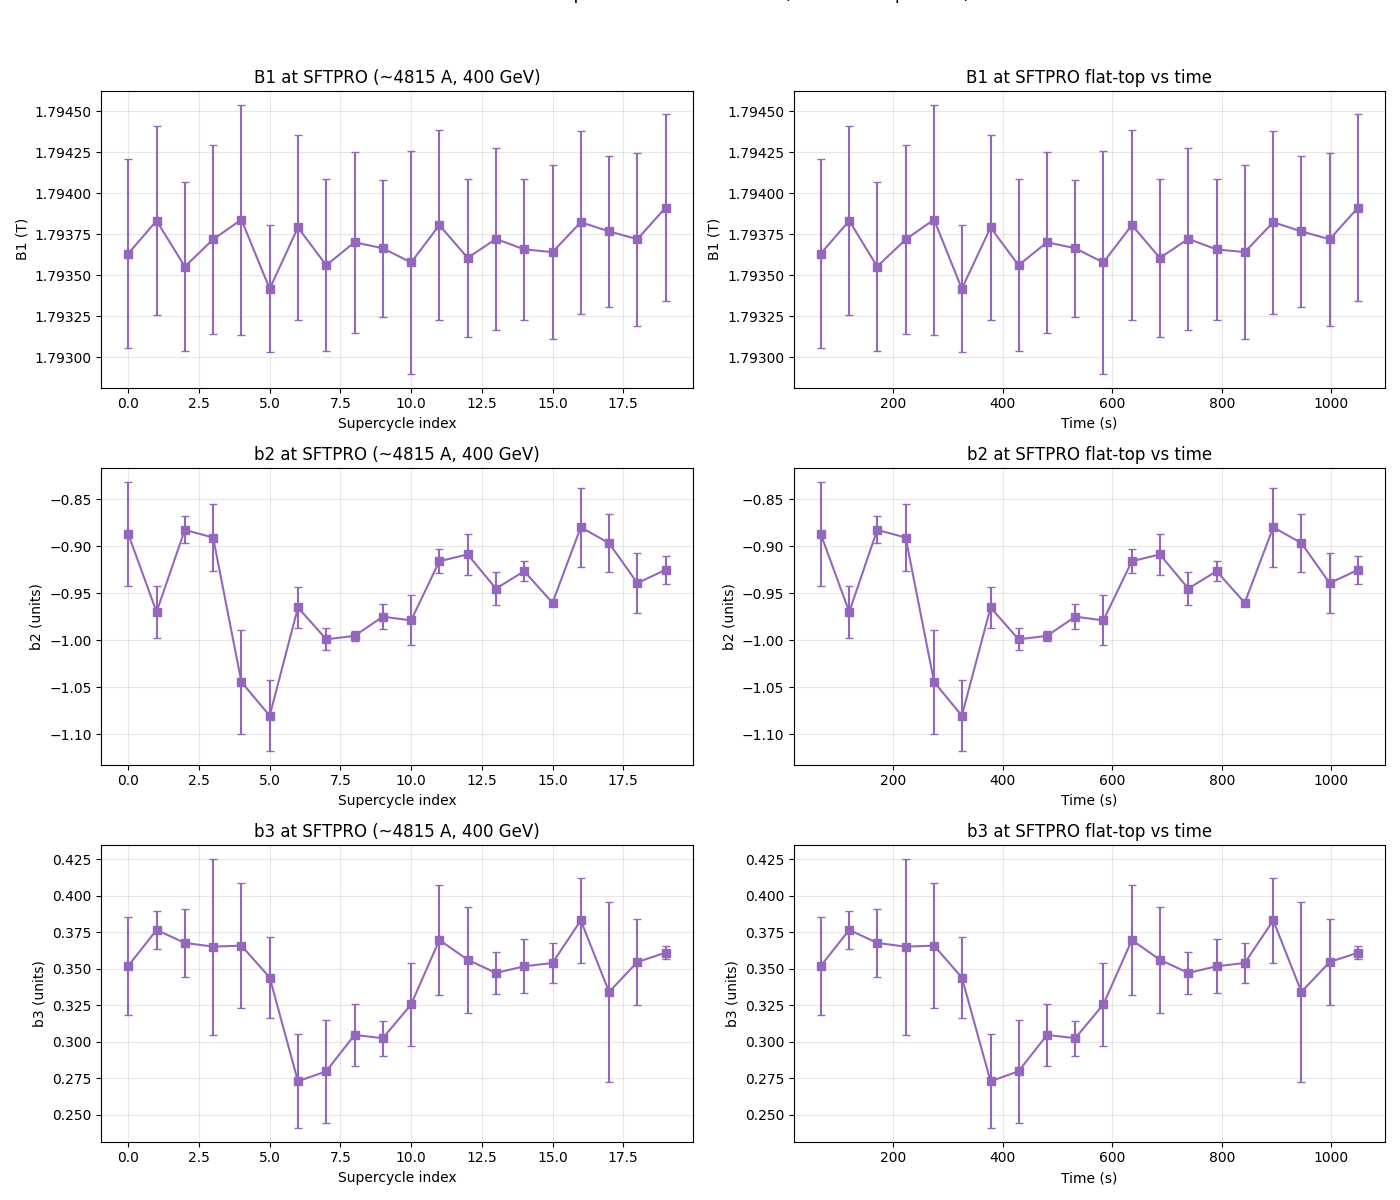


SFTPRO flat-top: per-supercycle summary (3-4 turns/SC, current NOT flat)
  SC     I(A)   I std          B1(T)      b2(u)      b3(u)    N
--------------------------------------------------------------
   0   4814.4   2.158     +1.7936332    -0.8868    +0.3519    4
   1   4814.9   2.098     +1.7938335    -0.9698    +0.3766    4
   2   4814.1   2.104     +1.7935541    -0.8824    +0.3677    4
   3   4814.7   1.995     +1.7937195    -0.8905    +0.3651    4
   4   4815.2   2.582     +1.7938406    -1.0444    +0.3658    3
   5   4813.4   1.555     +1.7934184    -1.0804    +0.3439    3
   6   4815.0   2.119     +1.7937925    -0.9651    +0.2728    4
   7   4814.1   2.177     +1.7935619    -0.9989    +0.2796    4
   8   4814.6   2.209     +1.7937021    -0.9953    +0.3046    4
   9   4814.4   1.648     +1.7936657    -0.9749    +0.3023    3
  10   4814.0   2.518     +1.7935788    -0.9788    +0.3255    3
  11   4814.9   2.146     +1.7938071    -0.9158    +0.3697    4
  12   4813.9   2.139     +1.79

In [112]:
# =====================================================================
# 11b) SFTPRO flat-top (~4815 A, 400 GeV) -- evolution over 20 SCs
# =====================================================================
# WARNING: the current is NOT truly flat here.  It ramps ~5 A over
# 3-4 turns (+4.8 A from first to last turn).  B1 changes therefore
# track the current ramp, not eddy-current transients.
# The "plateau" label is approximate at this time resolution.

if len(df_L) > 0 and "supercycle_idx" in df_L.columns:
    ok = df_L["ok_main"].values
    sft_ok = (df_L["plateau_role"] == "sftpro-flattop") & ok
    df_sft = df_L[sft_ok].copy()

    if len(df_sft) > 0:
        # Current flatness check
        I_all = df_sft["I_mean_A"].values
        print(f"SFTPRO flat-top -- current flatness check:")
        print(f"  I = {I_all.mean():.2f} +/- {I_all.std():.3f} A  "
              f"(p-p = {I_all.max() - I_all.min():.3f} A)")

        # Per turn-in-plateau stats
        if "turn_in_plateau" in df_sft.columns:
            for t in sorted(df_sft["turn_in_plateau"].unique()):
                sub = df_sft[df_sft["turn_in_plateau"] == t]
                print(f"  turn {int(t):d}: I = {sub['I_mean_A'].mean():.2f} "
                      f"+/- {sub['I_mean_A'].std():.3f} A")
            dI = (df_sft.groupby("turn_in_plateau")["I_mean_A"].mean()
                  .iloc[-1] -
                  df_sft.groupby("turn_in_plateau")["I_mean_A"].mean()
                  .iloc[0])
            print(f"  -> NOT A TRUE PLATEAU: current ramps {dI:+.1f} A "
                  f"over {int(df_sft['turn_in_plateau'].max())} turns")
            print(f"     B1 changes track the current ramp, "
                  f"not eddy-current settling.\n")

        sft_sc = df_sft.groupby("supercycle_idx").agg(
            B1_mean=("B1_T", "mean"),
            B1_std=("B1_T", "std"),
            B1_count=("B1_T", "count"),
            b2_mean=("b2_units", "mean"),
            b2_std=("b2_units", "std"),
            b3_mean=("b3_units", "mean"),
            b3_std=("b3_units", "std"),
            I_mean=("I_mean_A", "mean"),
            I_std=("I_mean_A", "std"),
            t_mean=("time_s", "mean"),
        ).reset_index()

        fig, axes = plt.subplots(3, 2, figsize=(14, 12))

        for row, (name, col_m, col_s, unit) in enumerate([
            ("B1", "B1_mean", "B1_std", "T"),
            ("b2", "b2_mean", "b2_std", "units"),
            ("b3", "b3_mean", "b3_std", "units"),
        ]):
            ax = axes[row, 0]
            ax.errorbar(
                sft_sc["supercycle_idx"], sft_sc[col_m],
                yerr=sft_sc[col_s].fillna(0),
                fmt="s-", color="tab:purple", markersize=6, capsize=3,
            )
            ax.set_xlabel("Supercycle index")
            ax.set_ylabel(f"{name} ({unit})")
            ax.set_title(f"{name} at SFTPRO (~4815 A, 400 GeV)")

            ax = axes[row, 1]
            ax.errorbar(
                sft_sc["t_mean"], sft_sc[col_m],
                yerr=sft_sc[col_s].fillna(0),
                fmt="s-", color="tab:purple", markersize=6, capsize=3,
            )
            ax.set_xlabel("Time (s)")
            ax.set_ylabel(f"{name} ({unit})")
            ax.set_title(f"{name} at SFTPRO flat-top vs time")

        fig.suptitle(
            "SFTPRO flat-top (400 GeV, ~4815 A)\n"
            "NB: current ramps ~5 A over 3-4 turns "
            "(NOT a true plateau)",
            fontsize=13, y=1.03,
        )
        plt.tight_layout()
        plt.show()

        # Table
        print("\nSFTPRO flat-top: per-supercycle summary "
              "(3-4 turns/SC, current NOT flat)")
        print(f"{'SC':>4s} {'I(A)':>8s} {'I std':>7s} "
              f"{'B1(T)':>14s} {'b2(u)':>10s} {'b3(u)':>10s} {'N':>4s}")
        print("-" * 62)
        for _, r in sft_sc.iterrows():
            print(f"{int(r['supercycle_idx']):4d} {r['I_mean']:8.1f} "
                  f"{r['I_std']:7.3f} "
                  f"{r['B1_mean']:+14.7f} "
                  f"{r['b2_mean']:+10.4f} "
                  f"{r['b3_mean']:+10.4f} "
                  f"{int(r['B1_count']):4d}")
    else:
        print("No SFTPRO flat-top turns.")

### 11c. Within-plateau settling (eddy current transients vs current ramp)

After a fast current ramp, **eddy currents** in the yoke laminations
and beam screen decay with time constants of seconds.  Even though the
magnet current may be steady, B1 and the harmonics can still evolve
within the first turns of the plateau.

However, we must first check whether the **current itself is truly flat**
during these "plateaus".  If the current is still ramping (even slowly),
field changes track the current -- not eddy currents.

Below we plot the **current** (top panel, red) together with B1, b2, b3
vs **turn index within the plateau** (0 = first turn after the ramp
ends), overlaying all 20 supercycles.  The black line shows the mean.

- If the current is flat and the field drifts --> eddy current transient
- If the current ramps and the field follows --> not a true plateau


MD1 injection (26 GeV, ~301 A)
  Total plateau turns (ok_main): 480
  Supercycles: 20
  Turns per SC: min=24, max=24, mean=24.0

  Current vs turn position within plateau:
   turn  I mean(A)  I std(A)  I p-p(A)
  ------------------------------------
      0     300.91     0.075     0.297
      1     300.89     0.079     0.280
      2     300.88     0.088     0.380
      3     300.92     0.087     0.386
      4     300.90     0.070     0.300
      5     300.93     0.111     0.403
      6     300.92     0.110     0.436
      7     300.90     0.070     0.265
      8     300.93     0.065     0.275
      9     300.91     0.112     0.477
     10     300.91     0.089     0.343
     11     300.89     0.062     0.309
     12     300.92     0.074     0.320
     13     300.90     0.076     0.324
     14     300.89     0.070     0.241
     15     300.91     0.082     0.338
     16     300.93     0.082     0.326
     17     300.88     0.075     0.341
     18     300.92     0.113     0.399
     19 

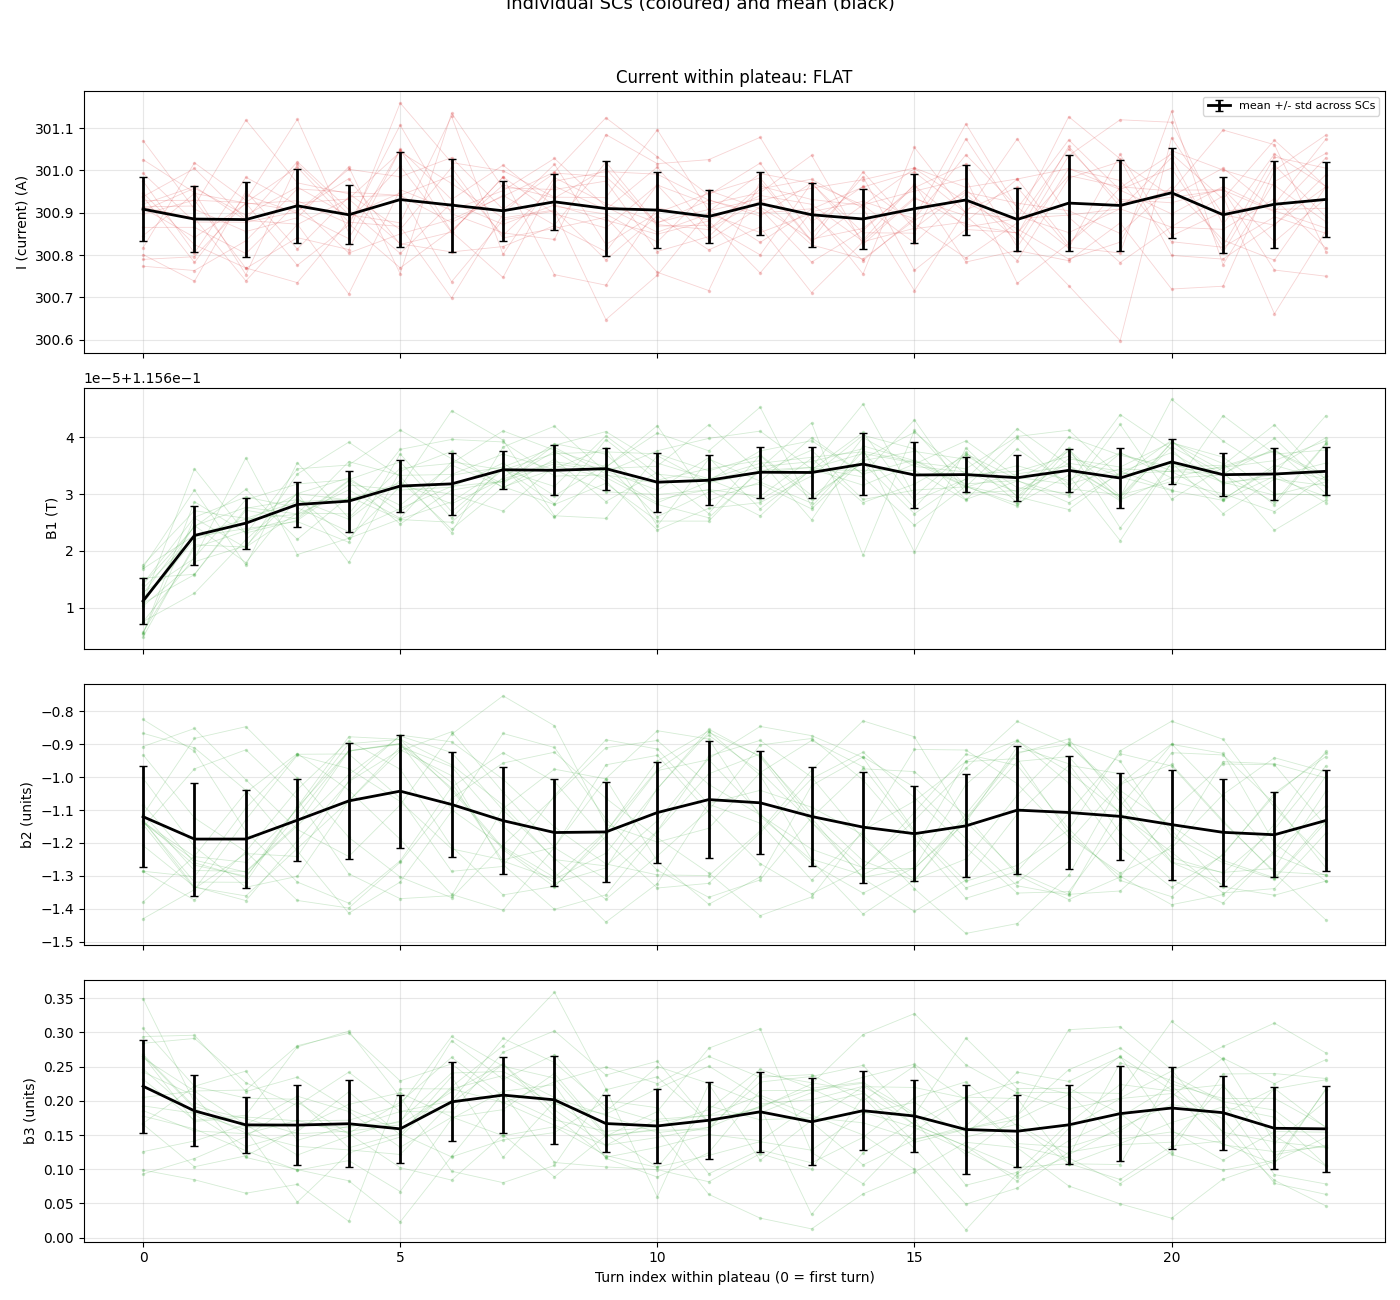


  Effect of excluding first N turns from plateau average:
  N excl N kept  I mean(A)      B1 mean (T)  b2 mean (u)  b3 mean (u)
  ------------------------------------------------------------------
       0    480     300.91       +0.1156314      -1.1285      +0.1767
       1    460     300.91       +0.1156322      -1.1289      +0.1747
       2    440     300.91       +0.1156327      -1.1262      +0.1742
       3    420     300.91       +0.1156330      -1.1232      +0.1747
       5    380     300.91       +0.1156335      -1.1255      +0.1757

  Shift relative to N_excl=0:
  N excl     dI (A)        dB1 (T)      db2 (u)      db3 (u)
  --------------------------------------------------------
       1     +0.000      +8.76e-07      -0.0004      -0.0019
       2     +0.001      +1.31e-06      +0.0023      -0.0024
       3     +0.002      +1.68e-06      +0.0053      -0.0020
       5     +0.003      +2.16e-06      +0.0030      -0.0010

SFTPRO flat-top (400 GeV, ~4815 A)
  Total plateau turns

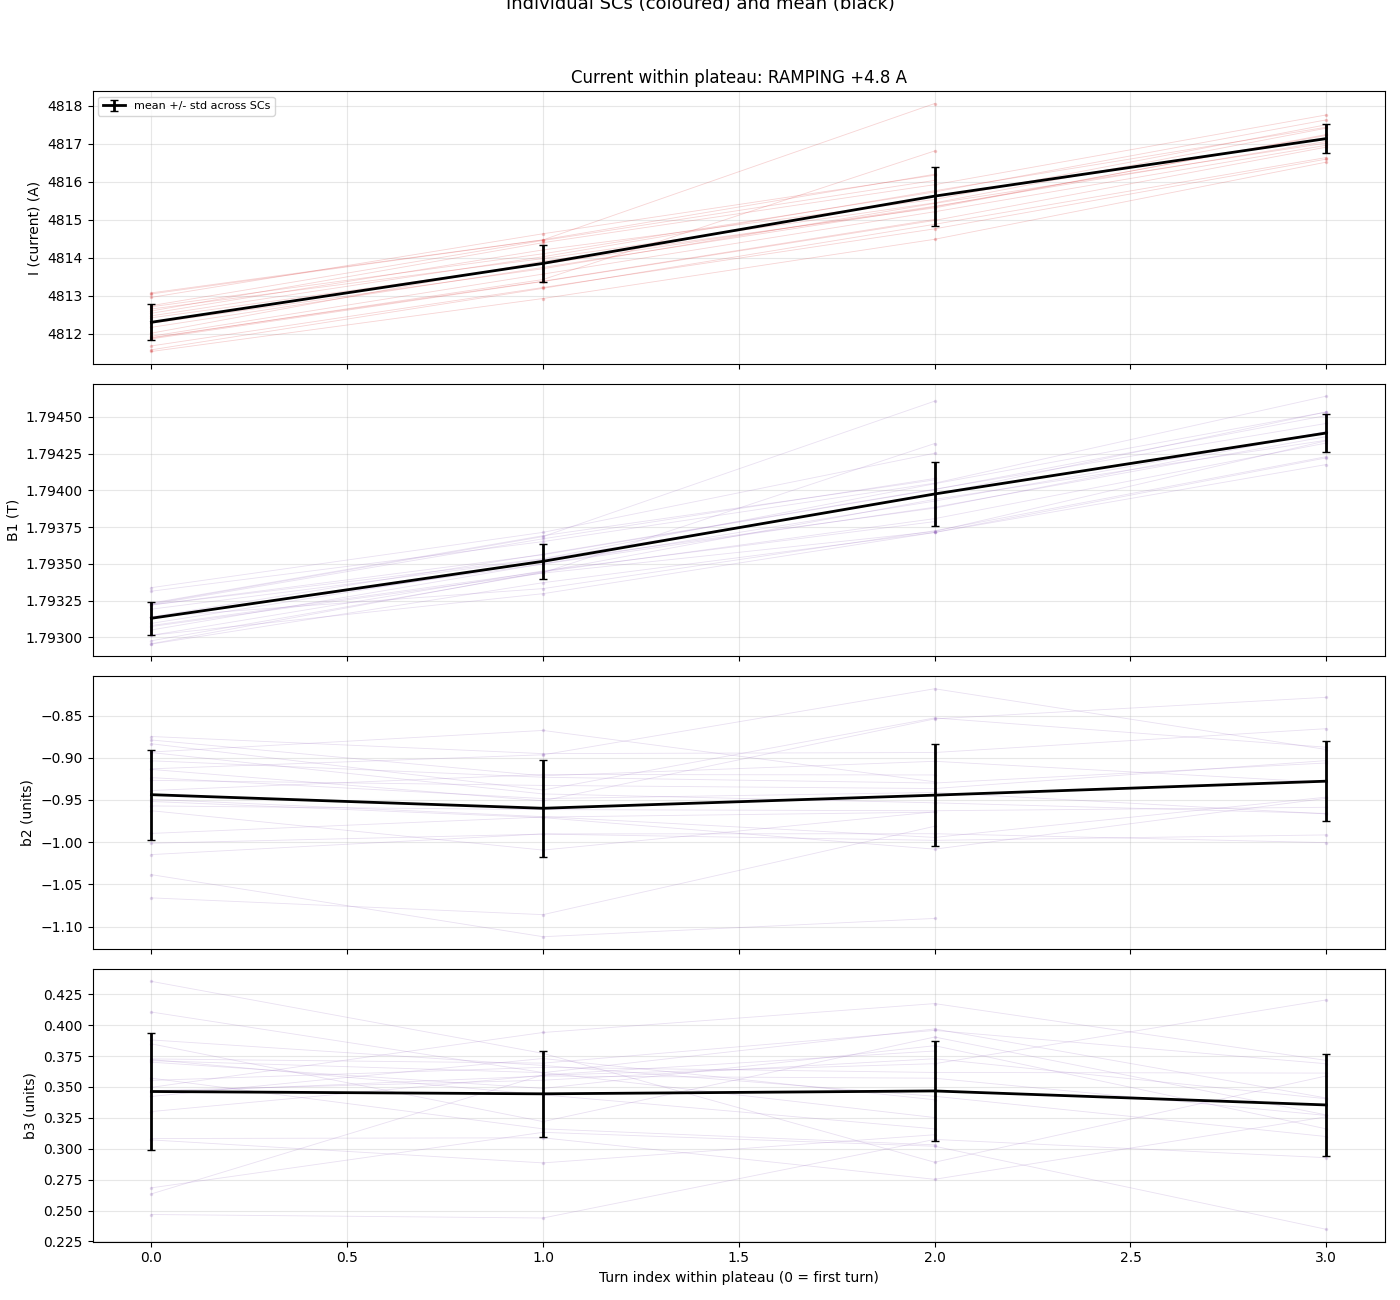


  Effect of excluding first N turns from plateau average:
  N excl N kept  I mean(A)      B1 mean (T)  b2 mean (u)  b3 mean (u)
  ------------------------------------------------------------------
       0     74    4814.54       +1.7937018      -0.9453      +0.3439
       1     54    4815.36       +1.7939132      -0.9458      +0.3430
       2     34    4816.25       +1.7941459      -0.9375      +0.3421
       3     14    4817.14       +1.7943897      -0.9278      +0.3354

  Shift relative to N_excl=0:
  N excl     dI (A)        dB1 (T)      db2 (u)      db3 (u)
  --------------------------------------------------------
       1     +0.826      +2.11e-04      -0.0005      -0.0009
       2     +1.712      +4.44e-04      +0.0077      -0.0018
       3     +2.602      +6.88e-04      +0.0175      -0.0084


In [113]:
# =====================================================================
# 11c) Within-plateau settling -- eddy current transients vs current ramp
# =====================================================================
# The top subplot shows the CURRENT to distinguish true eddy-current
# transients (field evolves at constant I) from a current ramp (field
# simply follows dI/dt).

if len(df_L) > 0 and "turn_in_plateau" in df_L.columns:
    ok = df_L["ok_main"].values

    for role, color, title_prefix in [
        ("md1-injection", "tab:green",
         "MD1 injection (26 GeV, ~301 A)"),
        ("sftpro-flattop", "tab:purple",
         "SFTPRO flat-top (400 GeV, ~4815 A)"),
    ]:
        role_ok = (df_L["plateau_role"] == role) & ok
        df_role = df_L[role_ok].copy()
        if len(df_role) == 0:
            continue

        # --- Turn count per supercycle ---
        tc = df_role.groupby("supercycle_idx")["turn_in_plateau"].agg(
            ["count", "max"])
        print(f"\n{'='*60}")
        print(f"{title_prefix}")
        print(f"{'='*60}")
        print(f"  Total plateau turns (ok_main): {len(df_role)}")
        print(f"  Supercycles: {tc.shape[0]}")
        print(f"  Turns per SC: min={tc['count'].min()}, "
              f"max={tc['count'].max()}, "
              f"mean={tc['count'].mean():.1f}")

        # Current statistics per turn_in_plateau
        tip_max = int(df_role["turn_in_plateau"].max())
        I_by_tip = []
        for t in range(tip_max + 1):
            vals = df_role.loc[
                df_role["turn_in_plateau"] == t, "I_mean_A"].values
            I_by_tip.append((t, vals.mean(), vals.std(),
                             vals.max() - vals.min()))

        print(f"\n  Current vs turn position within plateau:")
        print(f"  {'turn':>5s} {'I mean(A)':>10s} {'I std(A)':>9s} "
              f"{'I p-p(A)':>9s}")
        print(f"  {'-'*36}")
        for t, im, ist, ipp in I_by_tip:
            print(f"  {t:5d} {im:10.2f} {ist:9.3f} {ipp:9.3f}")

        I_first = I_by_tip[0][1]
        I_last = I_by_tip[-1][1]
        dI = I_last - I_first
        print(f"\n  Current drift (last - first turn): "
              f"{dI:+.3f} A over {tip_max} turns")

        # Verdict
        if abs(dI) < 0.5:
            print(f"  >>> TRUE PLATEAU: current is flat "
                  f"(drift {abs(dI):.3f} A)")
            plateau_verdict = "true"
        else:
            print(f"  >>> NOT A TRUE PLATEAU: current ramps "
                  f"{dI:+.1f} A")
            print(f"      B1 changes track the current ramp, "
                  f"not eddy currents.")
            plateau_verdict = "ramp"

        # --- Plot: current + B1 + b2 + b3 vs turn_in_plateau ---
        channels = [
            ("I (current)", "I_mean_A", "A", "tab:red"),
            ("B1", "B1_T", "T", color),
            ("b2", "b2_units", "units", color),
            ("b3", "b3_units", "units", color),
        ]
        fig, axes = plt.subplots(len(channels), 1, figsize=(14, 13),
                                 sharex=True)

        for row, (name, col, unit, lcolor) in enumerate(channels):
            ax = axes[row]

            # Overlay each supercycle as a thin line
            for sc_idx in sorted(df_role["supercycle_idx"].unique()):
                sc_data = df_role[df_role["supercycle_idx"] == sc_idx]
                tip = sc_data["turn_in_plateau"].values
                yvals = sc_data[col].values
                finite = np.isfinite(yvals)
                ax.plot(tip[finite], yvals[finite],
                        ".-", color=lcolor, alpha=0.2, linewidth=0.6,
                        markersize=3)

            # Mean +/- std across supercycles at each turn_in_plateau
            mean_tip, mean_val, std_val = [], [], []
            for t in range(tip_max + 1):
                vals = df_role.loc[
                    df_role["turn_in_plateau"] == t, col].values
                vals = vals[np.isfinite(vals)]
                if len(vals) > 0:
                    mean_tip.append(t)
                    mean_val.append(vals.mean())
                    std_val.append(vals.std())

            mean_tip = np.array(mean_tip)
            mean_val = np.array(mean_val)
            std_val = np.array(std_val)

            ax.errorbar(mean_tip, mean_val, yerr=std_val,
                        color="black", linewidth=2, capsize=3,
                        label="mean +/- std across SCs", zorder=10)
            ax.set_ylabel(f"{name} ({unit})")
            if row == 0:
                ax.legend(fontsize=8, loc="best")
                verdict_str = ("FLAT" if plateau_verdict == "true"
                               else f"RAMPING {dI:+.1f} A")
                ax.set_title(f"Current within plateau: {verdict_str}")

        axes[-1].set_xlabel(
            "Turn index within plateau (0 = first turn)")
        fig.suptitle(
            f"Within-plateau settling -- {title_prefix}\n"
            f"Individual SCs (coloured) and mean (black)",
            fontsize=13, y=1.02,
        )
        plt.tight_layout()
        plt.show()

        # --- Statistics: effect of excluding first N turns ---
        print(f"\n  Effect of excluding first N turns "
              f"from plateau average:")
        print(f"  {'N excl':>6s} {'N kept':>6s} "
              f"{'I mean(A)':>10s} {'B1 mean (T)':>16s} "
              f"{'b2 mean (u)':>12s} {'b3 mean (u)':>12s}")
        print(f"  {'-'*66}")

        for n_excl in [0, 1, 2, 3, 5]:
            sub = df_role[df_role["turn_in_plateau"] >= n_excl]
            if len(sub) == 0:
                continue
            Im = sub["I_mean_A"].mean()
            b1m = sub["B1_T"].mean()
            b2m = sub["b2_units"].mean()
            b3m = sub["b3_units"].mean()
            print(f"  {n_excl:6d} {len(sub):6d} "
                  f"{Im:10.2f} {b1m:+16.7f} "
                  f"{b2m:+12.4f} {b3m:+12.4f}")

        # Shift relative to full average (N_excl=0)
        full_I = df_role["I_mean_A"].mean()
        full_b1 = df_role["B1_T"].mean()
        full_b2 = df_role["b2_units"].mean()
        full_b3 = df_role["b3_units"].mean()
        print(f"\n  Shift relative to N_excl=0:")
        print(f"  {'N excl':>6s} {'dI (A)':>10s} {'dB1 (T)':>14s} "
              f"{'db2 (u)':>12s} {'db3 (u)':>12s}")
        print(f"  {'-'*56}")
        for n_excl in [1, 2, 3, 5]:
            sub = df_role[df_role["turn_in_plateau"] >= n_excl]
            if len(sub) == 0:
                continue
            dI = sub["I_mean_A"].mean() - full_I
            db1 = sub["B1_T"].mean() - full_b1
            db2 = sub["b2_units"].mean() - full_b2
            db3 = sub["b3_units"].mean() - full_b3
            print(f"  {n_excl:6d} {dI:+10.3f} {db1:+14.2e} "
                  f"{db2:+12.4f} {db3:+12.4f}")

#### Key findings: current flatness and eddy-current settling

| Plateau | Turns/SC | I drift (A) | Current flat? | Eddy-current transient? |
|---------|----------|-------------|---------------|------------------------|
| **MD1 injection** (301 A, 26 GeV) | 24 | +0.02 | **Yes** -- rock-steady | Tiny (~2 uT B1 rise in first 2-3 turns), negligible for averaging |
| **SFTPRO flat-top** (4815 A, 400 GeV) | 3-4 | **+4.8** | **No** -- current ramps | B1 rise (~1.3 mT over 4 turns) tracks the current ramp, not eddy currents |

**Conclusions:**

1. **MD1 injection is the only reliable plateau** for eddy-current and
   hysteresis studies.  All 24 turns can be safely averaged -- the
   eddy-current settling in the first 2-3 turns shifts B1 by < 2 uT,
   which is negligible compared to the turn-to-turn scatter.
2. **SFTPRO is not a true flat-top** at coil-turn time resolution.  The
   current increases by ~5 A across the 3-4 detected turns.  The
   monotonic B1 rise is simply the field following the current.  Care is
   needed when interpreting SFTPRO "plateau" averages -- they represent
   a short snapshot of a slow ramp, not a steady-state measurement.

C:\Users\albellel\AppData\Local\Temp\ipykernel_13296\3419728292.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


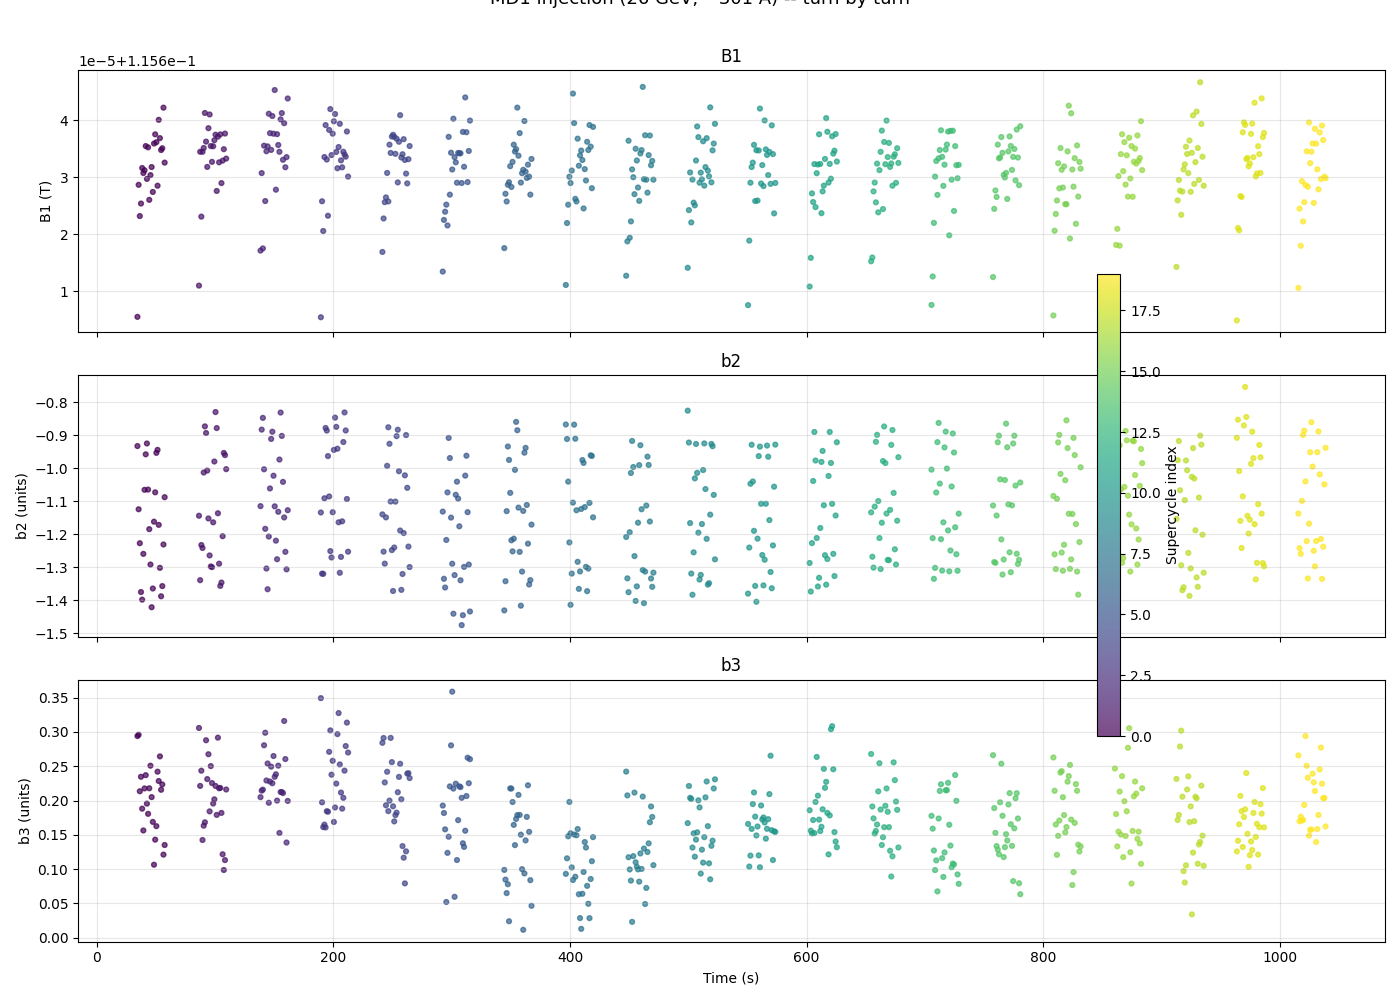

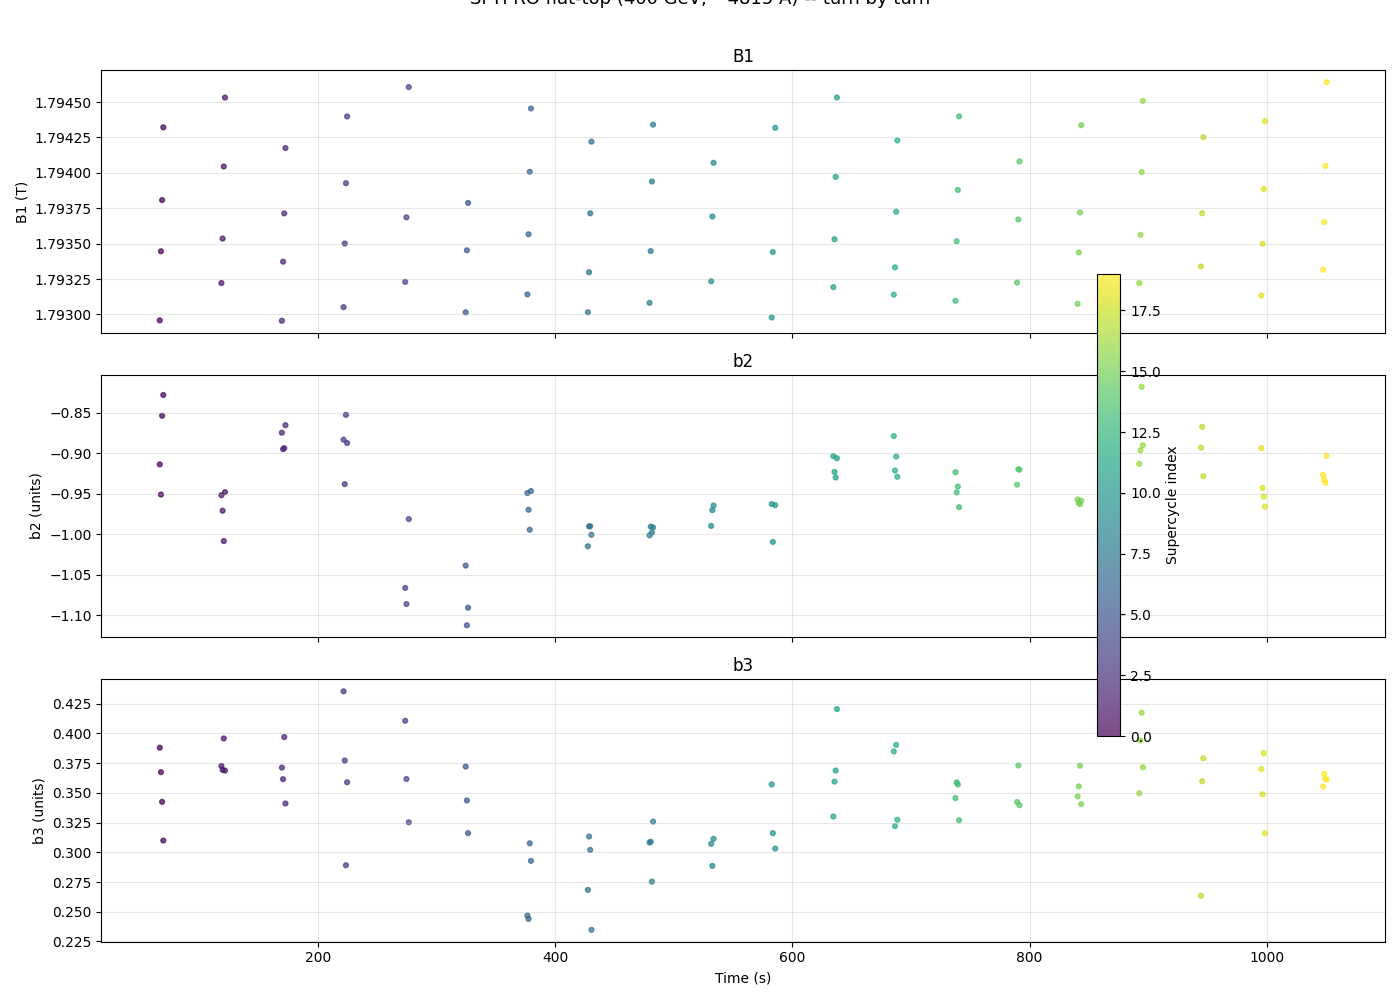

In [114]:
# =====================================================================
# 11d) Turn-by-turn detail at both plateaus (scatter vs time)
# =====================================================================
if len(df_L) > 0 and "plateau_role" in df_L.columns:
    ok = df_L["ok_main"].values

    for role, color, title_str in [
        ("md1-injection", "tab:green",
         "MD1 injection (26 GeV, ~301 A) -- turn by turn"),
        ("sftpro-flattop", "tab:purple",
         "SFTPRO flat-top (400 GeV, ~4815 A) -- turn by turn"),
    ]:
        role_ok = (df_L["plateau_role"] == role) & ok
        df_role = df_L[role_ok]
        if len(df_role) == 0:
            continue

        fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

        for row, (name, col, unit) in enumerate([
            ("B1", "B1_T", "T"),
            ("b2", "b2_units", "units"),
            ("b3", "b3_units", "units"),
        ]):
            ax = axes[row]
            finite = np.isfinite(df_role[col])
            sc_vals = df_role.loc[finite, "supercycle_idx"].values
            t_vals = df_role.loc[finite, "time_s"].values
            y_vals = df_role.loc[finite, col].values

            sc = ax.scatter(
                t_vals, y_vals,
                c=sc_vals, cmap="viridis", s=12, alpha=0.7,
                vmin=0, vmax=19,
            )
            ax.set_ylabel(f"{name} ({unit})")
            ax.set_title(f"{name}")

        axes[-1].set_xlabel("Time (s)")
        cbar = fig.colorbar(sc, ax=axes, label="Supercycle index",
                            shrink=0.6, pad=0.02)
        fig.suptitle(title_str, fontsize=13, y=1.01)
        plt.tight_layout()
        plt.show()

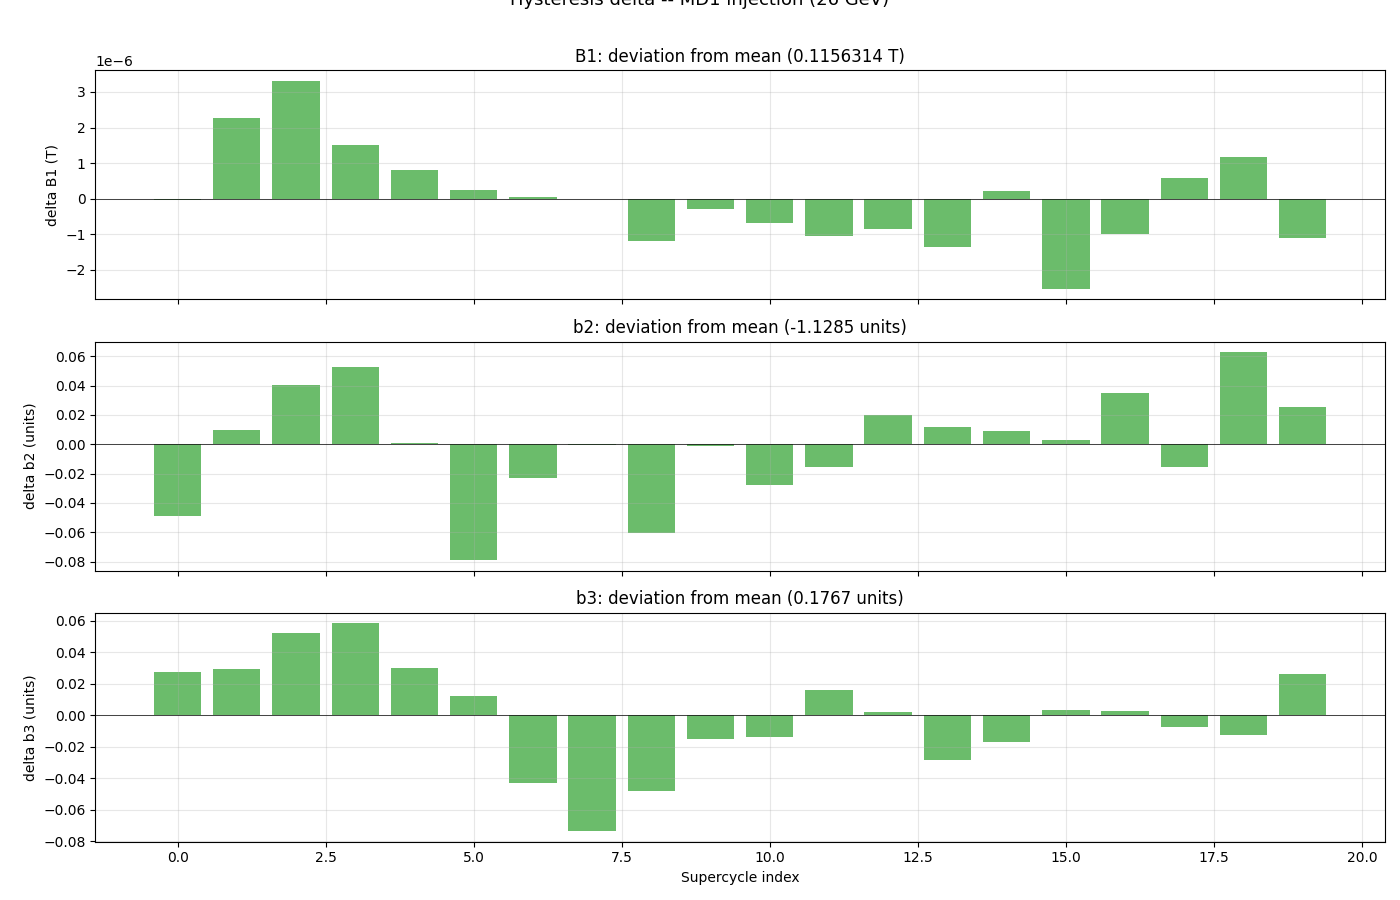

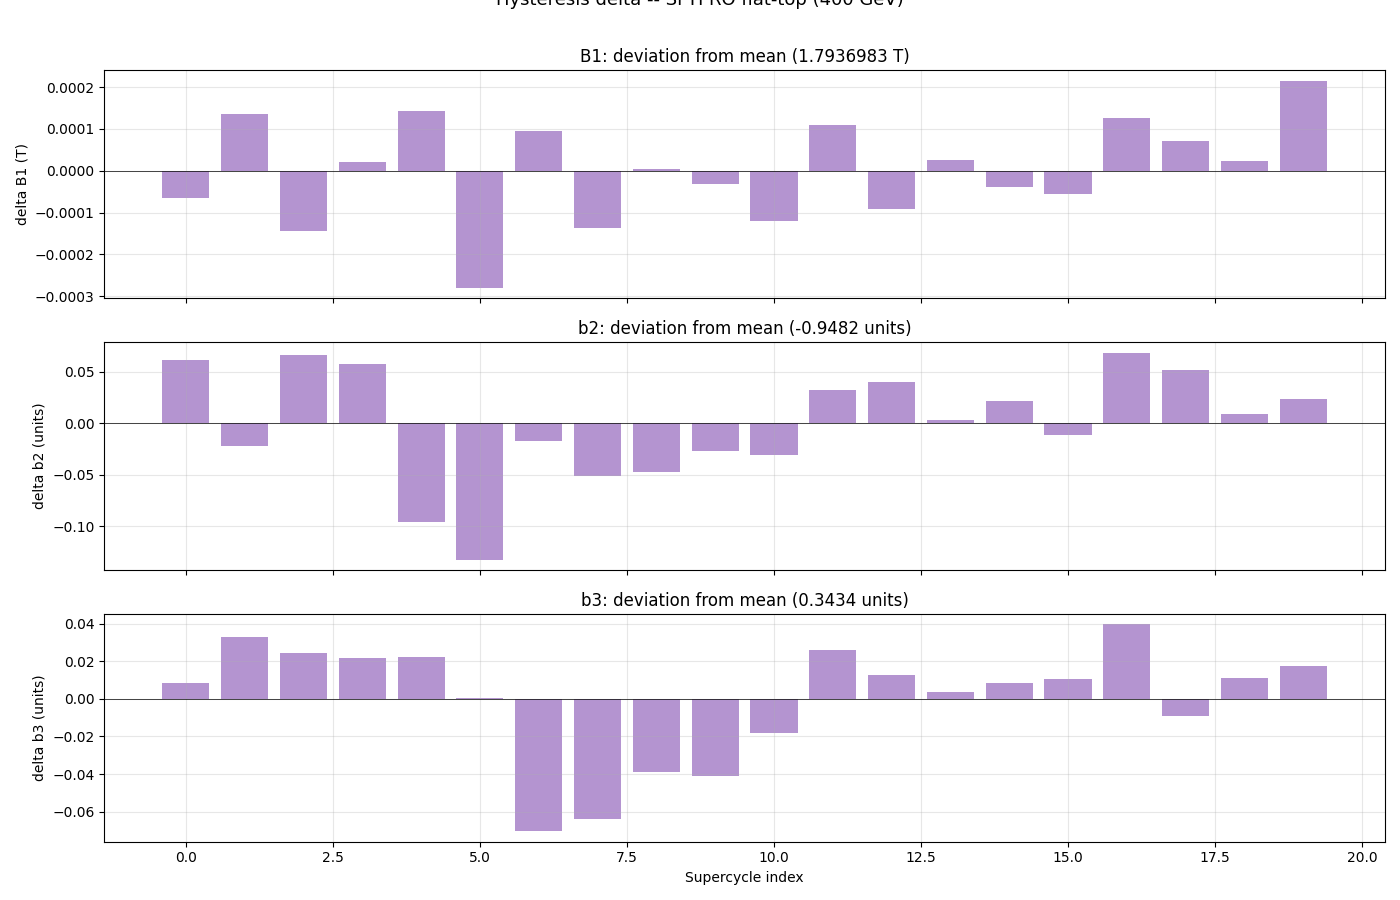


HYSTERESIS SUMMARY

  MD1 injection (26 GeV, ~301 A):
    20 supercycles, 480 total turns
    B1: peak-to-peak = 5.849939e-06 T, std = 1.324e-06, drift(last5-first5) = -2.150e-06 T
    b2: peak-to-peak = 1.417869e-01 units, std = 3.531e-02, drift(last5-first5) = +1.093e-02 units
    b3: peak-to-peak = 1.320418e-01 units, std = 3.247e-02, drift(last5-first5) = -3.709e-02 units

  SFTPRO flat-top (400 GeV, ~4815 A):
    20 supercycles, 74 total turns
    B1: peak-to-peak = 4.954859e-04 T, std = 1.180e-04, drift(last5-first5) = +5.781e-05 T
    b2: peak-to-peak = 2.007971e-01 units, std = 5.320e-02, drift(last5-first5) = +1.478e-02 units
    b3: peak-to-peak = 1.103584e-01 units, std = 3.038e-02, drift(last5-first5) = -8.084e-03 units


In [115]:
# =====================================================================
# 11e) Hysteresis delta: deviation from steady-state mean
# =====================================================================
# The first few supercycles may show the magnet conditioning toward
# cyclic steady state.  Here we plot the deviation from the overall mean
# for each supercycle to visualize the drift / settling.

if len(df_L) > 0 and "supercycle_idx" in df_L.columns:
    ok = df_L["ok_main"].values

    for role, color, role_label in [
        ("md1-injection", "tab:green", "MD1 injection (26 GeV)"),
        ("sftpro-flattop", "tab:purple", "SFTPRO flat-top (400 GeV)"),
    ]:
        role_ok = (df_L["plateau_role"] == role) & ok
        df_r = df_L[role_ok]
        if len(df_r) == 0:
            continue

        sc_agg = df_r.groupby("supercycle_idx").agg(
            B1_mean=("B1_T", "mean"),
            b2_mean=("b2_units", "mean"),
            b3_mean=("b3_units", "mean"),
        ).reset_index()

        fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

        for row, (name, col_m, unit, fmt_str) in enumerate([
            ("B1", "B1_mean", "T", ".7f"),
            ("b2", "b2_mean", "units", ".4f"),
            ("b3", "b3_mean", "units", ".4f"),
        ]):
            ax = axes[row]
            overall = sc_agg[col_m].mean()
            delta = sc_agg[col_m] - overall

            ax.bar(sc_agg["supercycle_idx"], delta,
                   color=color, alpha=0.7, width=0.8)
            ax.axhline(0, color="black", linewidth=0.5)
            ax.set_ylabel(f"delta {name} ({unit})")
            ax.set_title(
                f"{name}: deviation from mean "
                f"({overall:{fmt_str}} {unit})"
            )

        axes[-1].set_xlabel("Supercycle index")
        fig.suptitle(
            f"Hysteresis delta -- {role_label}",
            fontsize=13, y=1.01,
        )
        plt.tight_layout()
        plt.show()

    # --- Quantitative hysteresis summary ---
    print("\n" + "=" * 70)
    print("HYSTERESIS SUMMARY")
    print("=" * 70)

    for role, role_label in [
        ("md1-injection", "MD1 injection (26 GeV, ~301 A)"),
        ("sftpro-flattop", "SFTPRO flat-top (400 GeV, ~4815 A)"),
    ]:
        role_ok = (df_L["plateau_role"] == role) & ok
        df_r = df_L[role_ok]
        if len(df_r) == 0:
            continue

        sc_agg = df_r.groupby("supercycle_idx").agg(
            B1_mean=("B1_T", "mean"),
            b2_mean=("b2_units", "mean"),
            b3_mean=("b3_units", "mean"),
        ).reset_index()

        print(f"\n  {role_label}:")
        print(f"    {len(sc_agg)} supercycles, "
              f"{len(df_r)} total turns")

        for name, col_m, unit in [
            ("B1", "B1_mean", "T"),
            ("b2", "b2_mean", "units"),
            ("b3", "b3_mean", "units"),
        ]:
            vals = sc_agg[col_m].values
            pp = vals.max() - vals.min()
            # First vs last 5 supercycles
            first5 = vals[:5].mean() if len(vals) >= 5 else vals[0]
            last5 = vals[-5:].mean() if len(vals) >= 5 else vals[-1]
            drift = last5 - first5
            print(f"    {name}: peak-to-peak = {pp:.6e} {unit}, "
                  f"std = {vals.std():.3e}, "
                  f"drift(last5-first5) = {drift:+.3e} {unit}")

---
## 12. Summary & Export

In [116]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    print("=" * 70)
    print(f"SPS MBB DIPOLE -- {SEGMENT} STREAMING SUPERCYCLE ANALYSIS")
    print("=" * 70)

    print(f"\nMeasurement     : {SESSION}")
    print(f"Kn calibration  : {KN_PATH.name} (cross-session from MBA)")
    print(f"Supercycle      : LHC_pilot -> MD1 -> SFTPRO x{len(cycle_info)}")
    print(f"Total turns     : {n_turns}")
    print(f"Plateau turns   : {is_analysis.sum()} (I range < {PLATEAU_I_RANGE_MAX} A)")
    print(f"Ramp turns      : {n_turns - is_analysis.sum()} (excluded)")
    print(f"Time span       : {t_mean[-1] - t_mean[0]:.1f} s")

    # --- Plateau quality assessment ---
    print(f"\n{'─'*70}")
    print("PLATEAU QUALITY")
    print(f"{'─'*70}")
    if "turn_in_plateau" in df_L.columns and "plateau_role" in df_L.columns:
        ok = df_L["ok_main"].values
        for role, label, n_label in [
            ("md1-injection", "MD1 inj 26GeV", "24 turns/SC"),
            ("sftpro-flattop", "SFTPRO 400GeV", "3-4 turns/SC"),
        ]:
            sub = df_L[(df_L["plateau_role"] == role) & ok]
            if len(sub) == 0:
                continue
            I_by_tip = sub.groupby("turn_in_plateau")["I_mean_A"].mean()
            dI = I_by_tip.iloc[-1] - I_by_tip.iloc[0]
            n_tip = int(sub["turn_in_plateau"].max())
            flat = abs(dI) < 0.5
            verdict = "TRUE PLATEAU" if flat else f"NOT FLAT (I ramps {dI:+.1f} A)"
            print(f"  {label:>16s} : {n_label}, "
                  f"I drift = {dI:+.2f} A over {n_tip} turns "
                  f"-> {verdict}")

    # --- Results table ---
    print(f"\n{'─'*70}")
    print(f"{'Plateau':>16s} {'N':>5s} {'I (A)':>10s} {'B1 (T)':>12s} "
          f"{'TF (mT/A)':>12s} {'b2 (u)':>10s} {'b3 (u)':>10s}")
    print(f"{'─'*70}")

    plateau_map = [
        ("MD1 inj 26GeV", "md1-injection"),
        ("SFTPRO 400GeV*", "sftpro-flattop"),
    ]
    if "plateau_role" in df_L.columns:
        for disp_name, role in plateau_map:
            mask = (df_L["plateau_role"] == role) & df_L["ok_main"]
            if mask.sum() == 0:
                continue
            sub = df_L[mask]
            I_v = sub["I_mean_A"].values
            B1 = sub["B1_T"].values
            tf = B1 / I_v * 1e3
            b2 = sub["b2_units"].values
            b3 = sub["b3_units"].values
            b2_ok = b2[np.isfinite(b2)]
            b3_ok = b3[np.isfinite(b3)]
            print(f"{disp_name:>16s} {mask.sum():5d} {I_v.mean():10.1f} "
                  f"{B1.mean():+12.6f} {tf.mean():12.4f} "
                  f"{b2_ok.mean() if len(b2_ok) else float('nan'):+10.4f} "
                  f"{b3_ok.mean() if len(b3_ok) else float('nan'):+10.4f}")
    else:
        for lab in ["injection", "flat-mid", "flat-high"]:
            mask = (df_L["label"] == lab) & df_L["ok_main"]
            if mask.sum() == 0:
                continue
            sub = df_L[mask]
            I_v = sub["I_mean_A"].values
            B1 = sub["B1_T"].values
            tf = B1 / I_v * 1e3
            b2 = sub["b2_units"].values
            b3 = sub["b3_units"].values
            b2_ok = b2[np.isfinite(b2)]
            b3_ok = b3[np.isfinite(b3)]
            print(f"{lab:>16s} {mask.sum():5d} {I_v.mean():10.1f} "
                  f"{B1.mean():+12.6f} {tf.mean():12.4f} "
                  f"{b2_ok.mean() if len(b2_ok) else float('nan'):+10.4f} "
                  f"{b3_ok.mean() if len(b3_ok) else float('nan'):+10.4f}")

    print(f"\n* SFTPRO 'flat-top' is NOT truly flat: current ramps "
          f"~5 A over 3-4 turns.")
    print(f"  Values represent a short snapshot of a slow ramp, "
          f"not a steady-state measurement.")

    # --- Eddy-current settling (MD1 only) ---
    print(f"\n{'─'*70}")
    print("EDDY-CURRENT SETTLING (MD1 injection only)")
    print(f"{'─'*70}")
    if "turn_in_plateau" in df_L.columns:
        md1 = df_L[(df_L["plateau_role"] == "md1-injection") &
                    df_L["ok_main"]]
        if len(md1) > 0:
            b1_t0 = md1.loc[md1["turn_in_plateau"] == 0, "B1_T"].mean()
            b1_t2 = md1.loc[md1["turn_in_plateau"] == 2, "B1_T"].mean()
            b1_all = md1["B1_T"].mean()
            b1_excl2 = md1.loc[
                md1["turn_in_plateau"] >= 2, "B1_T"].mean()
            print(f"  B1(turn 0) = {b1_t0:+.7f} T")
            print(f"  B1(turn 2) = {b1_t2:+.7f} T")
            print(f"  B1 shift (turn 0 -> turn 2): "
                  f"{(b1_t2 - b1_t0)*1e6:+.1f} uT")
            print(f"  B1 mean (all turns):        {b1_all:+.7f} T")
            print(f"  B1 mean (excl first 2):     {b1_excl2:+.7f} T")
            print(f"  Shift from excluding first 2: "
                  f"{(b1_excl2 - b1_all)*1e6:+.1f} uT")
            print(f"  -> Negligible: all 24 turns can be safely averaged.")

    # --- Drift comparison ---
    print(f"\n{'─'*70}")
    print("DRIFT CORRECTION (legacy vs weighted)")
    print(f"{'─'*70}")
    for name, col in [("B1", "B1_T"), ("b2", "b2_units"), ("b3", "b3_units")]:
        if col not in df_L.columns:
            continue
        vL = df_L.loc[df_L["ok_main"], col].values
        vW = df_W.loc[df_W["ok_main"], col].values
        ok_both = np.isfinite(vL) & np.isfinite(vW)
        if ok_both.sum() > 0:
            d = vW[ok_both] - vL[ok_both]
            unit = "T" if "T" in col else "units"
            print(f"  {name:3s} RMS diff: {np.sqrt(np.mean(d**2)):.6e} {unit}")

SPS MBB DIPOLE -- NCS STREAMING SUPERCYCLE ANALYSIS

Measurement     : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
Kn calibration  : Kn_values_Seg_Main_A_AC.txt (cross-session from MBA)
Supercycle      : LHC_pilot -> MD1 -> SFTPRO x20
Total turns     : 1061
Plateau turns   : 562 (I range < 2.5 A)
Ramp turns      : 499 (excluded)
Time span       : 1060.0 s

──────────────────────────────────────────────────────────────────────
PLATEAU QUALITY
──────────────────────────────────────────────────────────────────────
     MD1 inj 26GeV : 24 turns/SC, I drift = +0.02 A over 23 turns -> TRUE PLATEAU
     SFTPRO 400GeV : 3-4 turns/SC, I drift = +4.83 A over 3 turns -> NOT FLAT (I ramps +4.8 A)

──────────────────────────────────────────────────────────────────────
         Plateau     N      I (A)       B1 (T)    TF (mT/A)     b2 (u)     b3 (u)
──────────────────────────────────────────────────────────────────────
   MD1 inj 26GeV   480      300.9    +0.115631       0.3843    -1.1285    

In [117]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    out_dir = REPO_ROOT / "output" / SESSION
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for label, df_out in [("legacy", df_L), ("weighted", df_W)]:
        fname = f"MBB_{SEGMENT}_streaming_plateau_{label}.csv"
        df_out.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(df_out)} rows)")
    
    print("\nDone.")

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\01_200_extended\20260206_144537_SPS_MBB\MBB_NCS_streaming_plateau_legacy.csv  (562 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\01_200_extended\20260206_144537_SPS_MBB\MBB_NCS_streaming_plateau_weighted.csv  (562 rows)

Done.
